**Proyecto Integrador - Movilidad inteligente: Prediciendo la afluencia en el Metro de Medellín**

**Integrantes: Santiago Areiza Tamayo, Santiago Carvajal Torres y Pedro Gómez Bedoya**

## Fase 1: Ingeniería de Datos y EDA

### 1.1. Comprensión de los Datos y Limpieza

In [17]:
import pandas as pd


# =================================================================
# FUNCIÓN DE PRE-PROCESAMIENTO Y LIMPIEZA DE DATOS
# =================================================================

def limpiar_datos(df_crudo, año):
    """
    Procesa un DataFrame cargado con header=[0, 1], despivota, limpia los datos,
    aplica el formato de fecha condicional y normaliza los nombres de línea.
    """

    # 1. --- Aplanar y Renombrar Encabezados ---
    nuevos_nombres = []

    for level_0, level_1 in df_crudo.columns:
        if 'Unnamed' in str(level_0):
            nuevos_nombres.append(level_1)
        elif level_0 == 'Hora de operación':
            nuevos_nombres.append(level_1)
        else:
            nuevos_nombres.append(level_0)

    df_crudo.columns = nuevos_nombres

    df_crudo.rename(columns={
        'Día': 'Día',
        'Línea de servicio': 'Línea de servicio',
        df_crudo.columns[1]: 'Línea de servicio'
    }, inplace=True)


    # 2. --- Aplicar el MELT (Despivotar) ---
    id_vars = ['Día', 'Línea de servicio']
    columnas_hora_melt = [
        col for col in df_crudo.columns
        if (':' in str(col) and 'Total' not in str(col))
    ]

    if len(id_vars) != 2:
        return None

    df_transformado = pd.melt(
        df_crudo,
        id_vars=id_vars,
        value_vars=columnas_hora_melt,
        var_name='Hora',
        value_name='Número de pasajeros'
    ).copy()

    # 3. --- Pasos de Limpieza Final ---

    # 3a. Conversión y NaN a Cero
    df_transformado['Número de pasajeros'] = pd.to_numeric(
        df_transformado['Número de pasajeros'],
        errors='coerce'
    ).fillna(0).astype(int)

    # 3b. CORRECCIÓN DE CAPITALIZACIÓN EN LÍNEA DE SERVICIO (Normalización)
    # Se unifica 'Línea 1', 'LÍNEA 1', 'linea 1' a 'Línea 1'
    df_transformado['Línea de servicio'] = (
        df_transformado['Línea de servicio']
        .astype(str)
        .str.replace('LÍNEA', 'Línea', case=False)
        .str.title()
        .str.replace('T-A', 'T-A', case=True) # Mantener T-A en mayúsculas
    )

    # 3c. Crear la columna de string 'Fecha y Hora' (limpiar segundos)
    df_transformado['Hora'] = df_transformado['Hora'].apply(lambda x: ':'.join(str(x).split(':')[:2]))

    fecha_hora_str = (
        df_transformado['Día'].astype(str).str.strip() + ' ' + df_transformado['Hora'].astype(str).str.strip()
    )

    # 3d. Convertir a datetime (Lógica de formato condicional con dayfirst)
    if 2023 <= año <= 2024:
        es_dia_primero = True # DD-MM-AA
    else:
        es_dia_primero = False # MM-DD-AA

    df_transformado['Fecha'] = pd.to_datetime(
        fecha_hora_str,
        errors='coerce',
        dayfirst=es_dia_primero,
        infer_datetime_format=True
    )

    # 3e. Formateo FINAL al string DD-MM-AAAA HH:MM:SS
    df_transformado['Fecha'] = df_transformado['Fecha'].dt.strftime('%d-%m-%Y %H:%M:%S')

    # 3f. Eliminar filas no válidas (donde la fecha falló)
    df_final = df_transformado.dropna(subset=['Fecha'])

    # 3g. Seleccionar las columnas finales solicitadas
    return df_final[['Fecha', 'Línea de servicio', 'Número de pasajeros']]

# =================================================================
# BUCLE DE PROCESAMIENTO Y CONSOLIDACIÓN (Generación de df_consolidado)
# =================================================================

ruta_archivo = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQAJ67ZteohcMJK6t5ntb_M3TWqh5Ydi5OjNrIRZl4Uw846Nx1bMMg15AlbKtM83A/pub?output=xlsx"
todos_los_datos = []
años = range(2019, 2026)

# (Opcional) Ver hojas disponibles por si algún nombre no coincide
with pd.ExcelFile(ruta_archivo) as xls:
    hojas_disponibles = set(xls.sheet_names)

for año in años:
    nombre_hoja = f"Afluencia_{año}"
    print("\n===============================")
    print(f"⌛ Procesando hoja: {nombre_hoja} (Año {año})...")

    try:
        # Si quieres, valida que la hoja exista antes de leer
        if 'hojas_disponibles' in locals() and nombre_hoja not in hojas_disponibles:
            raise ValueError(f"La hoja '{nombre_hoja}' no existe en el archivo. Hojas: {sorted(hojas_disponibles)}")

        df_anual = pd.read_excel(
            ruta_archivo,
            sheet_name=nombre_hoja,
            header=[0, 1]   # mantiene tu MultiIndex de columnas
        )

        df_limpio = limpiar_datos(df_anual, año)  # tu función
        if df_limpio is not None:
            todos_los_datos.append(df_limpio)
            print(f"✅ Hoja {nombre_hoja} procesada. Filas: {len(df_limpio)}")

    except Exception as e:
        print(f"❌ Error al procesar {nombre_hoja}: {e}")

if todos_los_datos:
    df_consolidado = pd.concat(todos_los_datos, ignore_index=True)
    print("\n===============================")
    print("🎉 ¡PROCESAMIENTO FINALIZADO Y CONSOLIDADO!")
    print(f"Dataset consolidado final de {len(df_consolidado)} registros.")
    print(df_consolidado.info())
    print("\nPrimeras filas del resultado:")
    print(df_consolidado.head())


⌛ Procesando hoja: Afluencia_2019 (Año 2019)...


/tmp/ipython-input-3783920938.py:83: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_transformado['Fecha'] = pd.to_datetime(


✅ Hoja Afluencia_2019 procesada. Filas: 71260

⌛ Procesando hoja: Afluencia_2020 (Año 2020)...


/tmp/ipython-input-3783920938.py:83: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_transformado['Fecha'] = pd.to_datetime(


✅ Hoja Afluencia_2020 procesada. Filas: 75280

⌛ Procesando hoja: Afluencia_2021 (Año 2021)...


/tmp/ipython-input-3783920938.py:83: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_transformado['Fecha'] = pd.to_datetime(


✅ Hoja Afluencia_2021 procesada. Filas: 82440

⌛ Procesando hoja: Afluencia_2022 (Año 2022)...


/tmp/ipython-input-3783920938.py:83: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_transformado['Fecha'] = pd.to_datetime(


✅ Hoja Afluencia_2022 procesada. Filas: 85840

⌛ Procesando hoja: Afluencia_2023 (Año 2023)...


/tmp/ipython-input-3783920938.py:83: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_transformado['Fecha'] = pd.to_datetime(


✅ Hoja Afluencia_2023 procesada. Filas: 86060

⌛ Procesando hoja: Afluencia_2024 (Año 2024)...


/tmp/ipython-input-3783920938.py:83: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_transformado['Fecha'] = pd.to_datetime(


✅ Hoja Afluencia_2024 procesada. Filas: 85880

⌛ Procesando hoja: Afluencia_2025 (Año 2025)...


/tmp/ipython-input-3783920938.py:83: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_transformado['Fecha'] = pd.to_datetime(


✅ Hoja Afluencia_2025 procesada. Filas: 42520

🎉 ¡PROCESAMIENTO FINALIZADO Y CONSOLIDADO!
Dataset consolidado final de 529280 registros.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529280 entries, 0 to 529279
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Fecha                529280 non-null  object
 1   Línea de servicio    529280 non-null  object
 2   Número de pasajeros  529280 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 12.1+ MB
None

Primeras filas del resultado:
                 Fecha Línea de servicio  Número de pasajeros
0  01-01-2019 04:00:00           Línea 1                   12
1  02-01-2019 04:00:00           Línea 1                 1716
2  03-01-2019 04:00:00           Línea 1                 1860
3  04-01-2019 04:00:00           Línea 1                 1845
4  05-01-2019 04:00:00           Línea 1                 1550


### 1.2. Análisis Exploratorio de Datos (EDA)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# =================================================================
# INGENIERÍA DE CARACTERÍSTICAS TEMPORALES PARA EL EDA
# =================================================================

# 1. Convertir 'Fecha' de string (object) a datetime para extracción
# Crucial: Usar el formato FINAL ('%d-%m-%Y %H:%M:%S')
df_consolidado['Fecha_dt'] = pd.to_datetime(
    df_consolidado['Fecha'],
    format='%d-%m-%Y %H:%M:%S',
    errors='coerce'
)

# 2. Crear nuevas columnas de tiempo usando la columna 'Fecha_dt'
df_consolidado['Año'] = df_consolidado['Fecha_dt'].dt.year
df_consolidado['Mes'] = df_consolidado['Fecha_dt'].dt.month
# Usamos 'dayofweek' y luego un mapeo para asegurar el idioma español y el orden
df_consolidado['Día_Num'] = df_consolidado['Fecha_dt'].dt.dayofweek # 0=Lunes, 6=Domingo
df_consolidado['Hora'] = df_consolidado['Fecha_dt'].dt.hour # Hora

# 3. Definir y mapear los días de la semana en español y ordenados
orden_dias_espanol = [
    'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'
]
mapa_dias = {
    0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'
}

# Creamos la columna 'Día_Semana' limpia y en español
df_consolidado['Día_Semana'] = df_consolidado['Día_Num'].map(mapa_dias)

# Establecemos el tipo Categórico para ordenar la gráfica
df_consolidado['Día_Semana'] = pd.Categorical(
    df_consolidado['Día_Semana'],
    categories=orden_dias_espanol,
    ordered=True
)

# Eliminamos filas con fecha nula si las hay
df_consolidado.dropna(subset=['Fecha_dt'], inplace=True)

print("✅ Columnas temporales creadas correctamente (Año, Mes, Día_Semana, Hora).")
print(df_consolidado[['Fecha_dt', 'Día_Semana', 'Hora']].head())

✅ Columnas temporales creadas correctamente (Año, Mes, Día_Semana, Hora).
             Fecha_dt Día_Semana  Hora
0 2019-01-01 04:00:00     Martes     4
1 2019-01-02 04:00:00  Miércoles     4
2 2019-01-03 04:00:00     Jueves     4
3 2019-01-04 04:00:00    Viernes     4
4 2019-01-05 04:00:00     Sábado     4


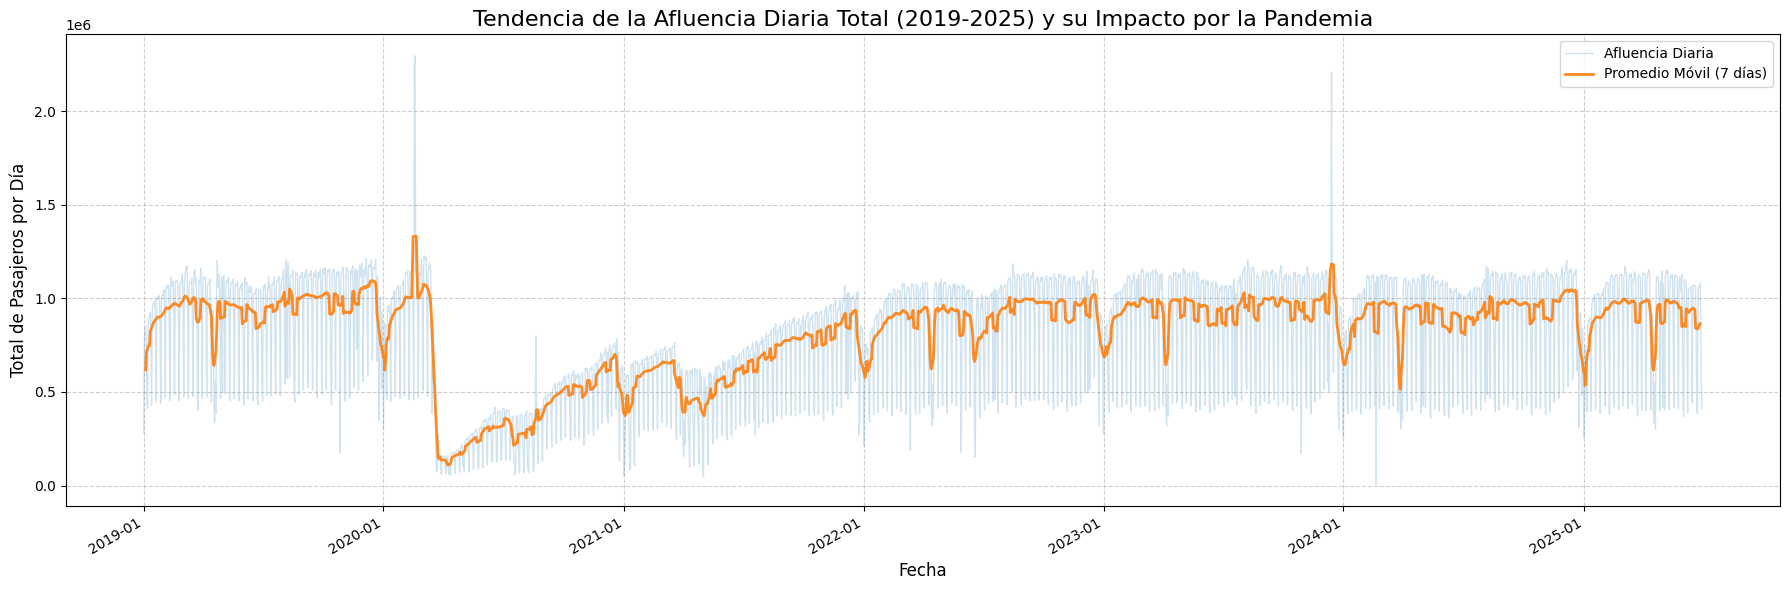

In [19]:
# =================================================================
# TENDENCIA DIARIA DE LA AFLUENCIA TOTAL (ANOMALÍAS/PANDEMIA)
# =================================================================


# 1. Agrupar la afluencia total por día (sumando todas las líneas y horas)
df_diario = df_consolidado.groupby('Fecha_dt')['Número de pasajeros'].sum().reset_index()

# Para el análisis de tendencia, solo necesitamos el componente de la fecha (sin hora)
df_diario['Fecha_Solo_Dia'] = df_diario['Fecha_dt'].dt.normalize()
df_diario = df_diario.groupby('Fecha_Solo_Dia')['Número de pasajeros'].sum().reset_index()
df_diario.columns = ['Fecha', 'Afluencia_Total']

# 2. Aplicar un Promedio Móvil (Rolling Mean) para suavizar la tendencia
# Usaremos una ventana de 7 días para suavizar la variación semanal (fin de semana vs. laboral)
df_diario['Promedio_Movil_7D'] = df_diario['Afluencia_Total'].rolling(window=7, center=True).mean()


# 3. Generación del Gráfico de Líneas
plt.figure(figsize=(18, 6))

# A. Trazar la afluencia diaria (como referencia, con transparencia)
plt.plot(
    df_diario['Fecha'],
    df_diario['Afluencia_Total'],
    label='Afluencia Diaria',
    alpha=0.2, # Baja transparencia para que no domine
    color='#1f77b4',
    linewidth=1
)

# B. Trazar el Promedio Móvil (para ver la tendencia limpia)
plt.plot(
    df_diario['Fecha'],
    df_diario['Promedio_Movil_7D'],
    label='Promedio Móvil (7 días)',
    alpha=0.9,
    color='#ff7f0e', # Naranja para la tendencia
    linewidth=2
)

# Configuración de Ejes
plt.title('Tendencia de la Afluencia Diaria Total (2019-2025) y su Impacto por la Pandemia', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Total de Pasajeros por Día', fontsize=12)
plt.legend(loc='upper right')

# Configuración del eje X para mejor visualización de años
locator = mdates.YearLocator()
formatter = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.grid(True, linestyle='--', alpha=0.6)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

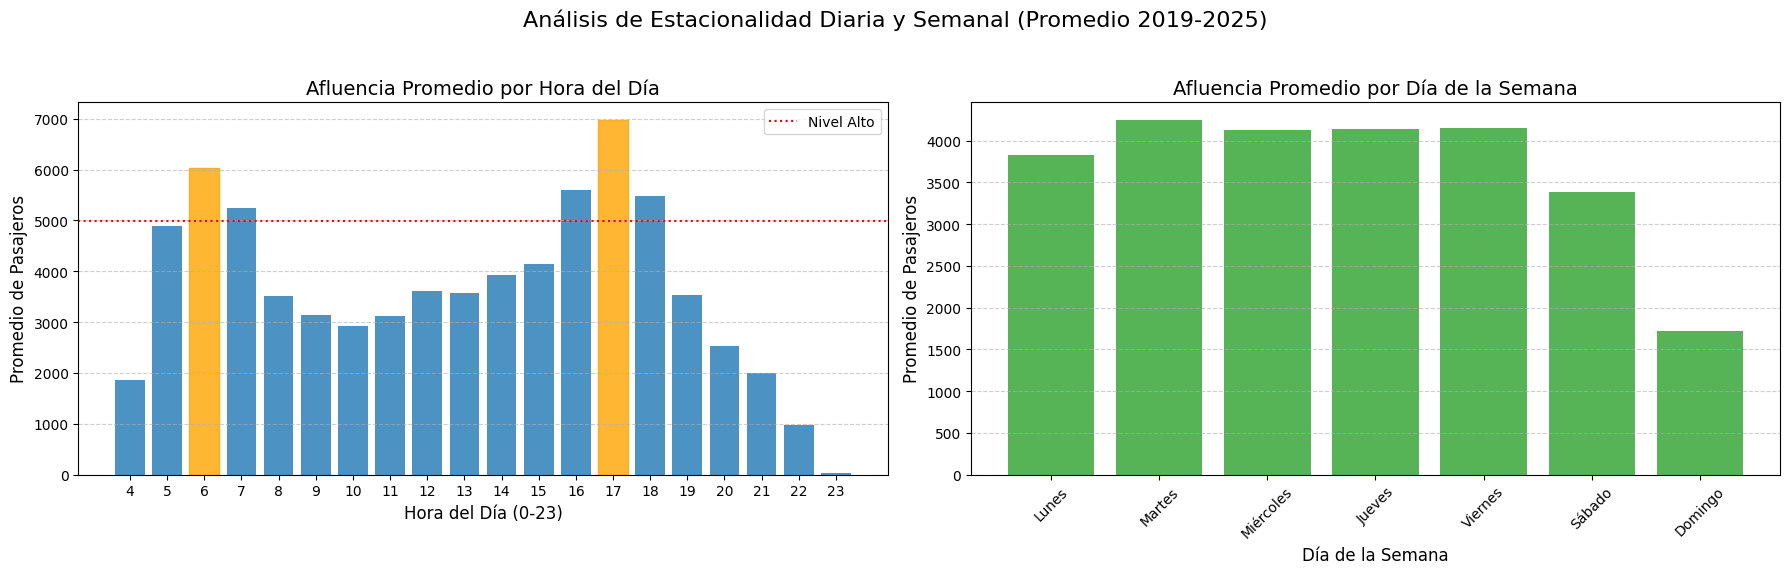

In [20]:
# =================================================================
# VISUALIZACIONES CLAVE DE ESTACIONALIDAD
# =================================================================

# 1. Patrón Horario Promedio (Afluencia promedio por hora en todo el dataset)
afluencia_horaria = df_consolidado.groupby('Hora')['Número de pasajeros'].mean().reset_index()

# 2. Patrón Semanal Promedio (Afluencia promedio por día de la semana)
afluencia_semanal = df_consolidado.groupby('Día_Semana', observed=False)['Número de pasajeros'].mean().reset_index()


# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Análisis de Estacionalidad Diaria y Semanal (Promedio 2019-2025)', fontsize=16)


# --- Gráfico 1: Patrón Horario ---
# Calcular el 3er cuartil para la afluencia horaria
q3 = afluencia_horaria['Número de pasajeros'].quantile(0.75)

# Identificar las dos horas con mayor afluencia
top_2_horas = afluencia_horaria.nlargest(2, 'Número de pasajeros')['Hora'].tolist()

bars = axes[0].bar(
    afluencia_horaria['Hora'],
    afluencia_horaria['Número de pasajeros'],
    color='#1f77b4', # Default color
    alpha=0.8
)

# Cambiar el color de las 2 barras con mayor valor
for bar, hora in zip(bars, afluencia_horaria['Hora']):
    if hora in top_2_horas:
        bar.set_color('orange') # Color para las dos barras más altas

axes[0].set_title('Afluencia Promedio por Hora del Día', fontsize=14)
axes[0].set_xlabel('Hora del Día (0-23)', fontsize=12)
axes[0].set_ylabel('Promedio de Pasajeros', fontsize=12)
axes[0].set_xticks(afluencia_horaria['Hora'])
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Añadir línea punteada roja para el 3er cuartil
axes[0].axhline(y=q3, color='red', linestyle=':', label='Nivel Alto')
axes[0].legend()


# --- Gráfico 2: Patrón Semanal ---
axes[1].bar(
    afluencia_semanal['Día_Semana'],
    afluencia_semanal['Número de pasajeros'],
    color='#2ca02c',
    alpha=0.8
)
axes[1].set_title('Afluencia Promedio por Día de la Semana', fontsize=14)
axes[1].set_xlabel('Día de la Semana', fontsize=12)
axes[1].set_ylabel('Promedio de Pasajeros', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

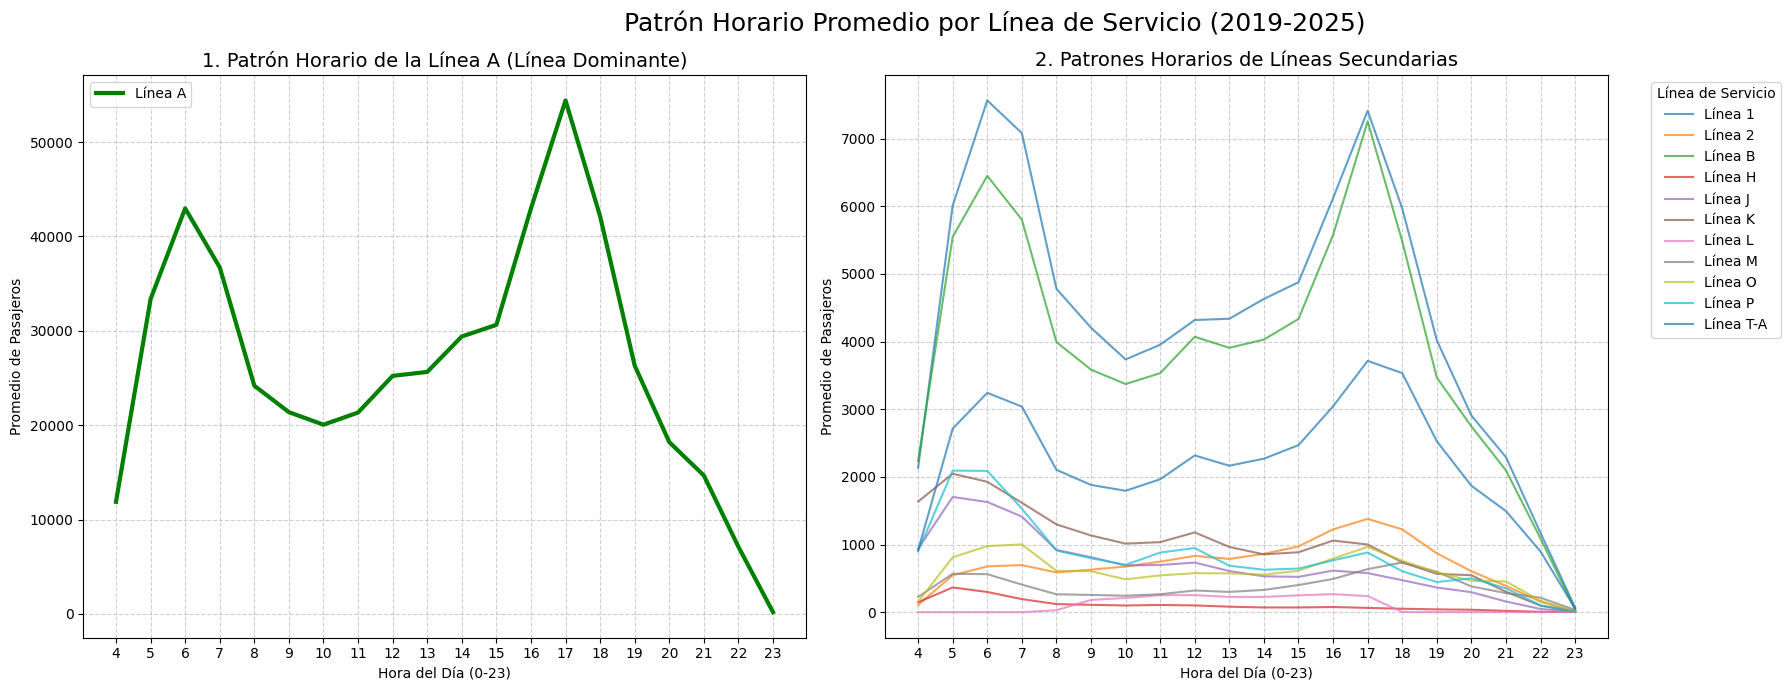

In [21]:
# =================================================================
# ESTACIONALIDAD HORARIA POR GRUPOS DE LÍNEA (Small Multiples)
# =================================================================

# 1. Agrupar la afluencia promedio por 'Hora' y 'Línea de servicio'
afluencia_horaria_por_linea = df_consolidado.groupby(['Hora', 'Línea de servicio'])['Número de pasajeros'].mean().reset_index()

# 2. Definir los grupos de líneas
linea_dominante = 'Línea A'
otras_lineas = [linea for linea in afluencia_horaria_por_linea['Línea de servicio'].unique() if linea != linea_dominante]

# 3. Preparar los datos para cada grupo
df_dominante = afluencia_horaria_por_linea[afluencia_horaria_por_linea['Línea de servicio'] == linea_dominante]
df_secundarias = afluencia_horaria_por_linea[afluencia_horaria_por_linea['Línea de servicio'] != linea_dominante]

# 4. Crear la figura con dos subplots en una fila
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Patrón Horario Promedio por Línea de Servicio (2019-2025)', fontsize=18)

# --- GRÁFICO 1: LÍNEA DOMINANTE (Línea A) ---
ax1 = axes[0]
ax1.plot(
    df_dominante['Hora'],
    df_dominante['Número de pasajeros'],
    label=linea_dominante,
    color='green',
    linewidth=3
)
ax1.set_title(f'1. Patrón Horario de la {linea_dominante} (Línea Dominante)', fontsize=14)
ax1.set_xlabel('Hora del Día (0-23)')
ax1.set_ylabel('Promedio de Pasajeros')
ax1.set_xticks(df_dominante['Hora'].unique())
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(loc='upper left')


# --- GRÁFICO 2: OTRAS LÍNEAS DE SERVICIO (Escala de comparación) ---
ax2 = axes[1]

# Graficar cada línea secundaria
for linea in otras_lineas:
    df_linea_horaria = df_secundarias[df_secundarias['Línea de servicio'] == linea]

    ax2.plot(
        df_linea_horaria['Hora'],
        df_linea_horaria['Número de pasajeros'],
        label=linea,
        alpha=0.7,
        linewidth=1.5
    )

ax2.set_title('2. Patrones Horarios de Líneas Secundarias', fontsize=14)
ax2.set_xlabel('Hora del Día (0-23)')
ax2.set_ylabel('Promedio de Pasajeros')
ax2.set_xticks(df_secundarias['Hora'].unique())
ax2.grid(True, linestyle='--', alpha=0.6)

# Colocar la leyenda fuera del segundo gráfico
ax2.legend(title='Línea de Servicio', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.9, 1]) # Ajustar el diseño para acomodar la leyenda
plt.show()

### 1.3. Extracción de Variables Exógenas

In [22]:
import holidays

# =================================================================
# CREACIÓN DE LA VARIABLE ES_FESTIVO
# =================================================================


# 1. Definir el rango de años de tu dataset (2019 a 2025)
inicio_año = df_consolidado['Fecha_dt'].min().year
fin_año = df_consolidado['Fecha_dt'].max().year

# 2. Generar todos los días festivos para Colombia en ese rango
# El objeto holidays ya tiene todas las reglas de Colombia (CO)
dias_festivos_colombia = holidays.CountryHoliday('CO', years=range(inicio_año, fin_año + 1))

# 3. Crear un conjunto (set) de las fechas de los días festivos para una búsqueda rápida
# Nota: La comparación se hace a nivel de fecha (dt.date) ya que los festivos son de día completo.
festivos_set = set(dias_festivos_colombia.keys())

# 4. Crear la columna 'Es_Festivo' en el DataFrame consolidado
# Si la fecha del registro (sin la hora) está en el set de festivos, la marca con 1.
df_consolidado['Es_Festivo'] = df_consolidado['Fecha_dt'].dt.date.apply(lambda x: 1 if x in festivos_set else 0)

# Verificación de un día festivo conocido (ej. 25 de Diciembre de 2023)
fecha_ejemplo = pd.to_datetime('2023-12-25').date()
es_festivo_ejemplo = df_consolidado[df_consolidado['Fecha_dt'].dt.date == fecha_ejemplo]['Es_Festivo'].iloc[0]

print(f"\nVerificación: ¿Es festivo el 2023-12-25? {'Sí' if es_festivo_ejemplo == 1 else 'No'}")
print(f"Número de días festivos únicos en el dataset: {len(festivos_set)}")
df_consolidado.head(4)


Verificación: ¿Es festivo el 2023-12-25? Sí
Número de días festivos únicos en el dataset: 124


,Fecha,Línea de servicio,Número de pasajeros,Fecha_dt,Año,Mes,Día_Num,Hora,Día_Semana,Es_Festivo
0,01-01-2019 04:00:00,Línea 1,12,2019-01-01 04:00:00,2019,1,1,4,Martes,1
1,02-01-2019 04:00:00,Línea 1,1716,2019-01-02 04:00:00,2019,1,2,4,Miércoles,0
2,03-01-2019 04:00:00,Línea 1,1860,2019-01-03 04:00:00,2019,1,3,4,Jueves,0
3,04-01-2019 04:00:00,Línea 1,1845,2019-01-04 04:00:00,2019,1,4,4,Viernes,0


### 1.4. Definición del Split Temporal

In [7]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 15.0 MB/s eta 0:00:00


In [23]:
from sktime.forecasting.model_selection import temporal_train_test_split

# =================================================================
# PREPARACIÓN: Preparación de Datos y Filtro Post-Pandemia
# =================================================================

# Fecha de inicio de modelado (excluyendo la anomalía 2020-2021)
FECHA_INICIO_MODELO = pd.to_datetime('2022-01-01 00:00:00')

# Filtramos el DataFrame para el modelado
df_modelo_filtered = df_consolidado[df_consolidado['Fecha_dt'] >= FECHA_INICIO_MODELO].copy()

# Agregamos 'Número de pasajeros' por 'Fecha_dt' y tomamos el primer 'Es_Festivo'
# (asumiendo que 'Es_Festivo' es consistente para una fecha dada)
df_modelo = df_modelo_filtered.groupby('Fecha_dt').agg(
    {'Número de pasajeros': 'sum',
     'Es_Festivo': 'first' # Tomamos el primer valor, ya que debería ser el mismo para una fecha
    }
)
df_modelo.sort_index(inplace=True)

# --- NUEVA LÍNEA: Establecer la frecuencia del índice a horario ('H') ---
# Esto es crucial para statsmodels. asfreq() puede introducir NaNs si hay huecos,
# así que los rellenamos adecuadamente.
df_modelo = df_modelo.asfreq('H')
df_modelo['Número de pasajeros'] = df_modelo['Número de pasajeros'].fillna(0)
df_modelo['Es_Festivo'] = df_modelo['Es_Festivo'].ffill().fillna(0) # Forward fill y luego 0 para NaNs iniciales


print("\n📊 Datos de modelado filtrados y listos para sktime (agregados por Fecha_dt).")


📊 Datos de modelado filtrados y listos para sktime (agregados por Fecha_dt).


/tmp/ipython-input-2086861025.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_modelo = df_modelo.asfreq('H')


In [24]:
# =================================================================
# SPLIT: Implementación del Triple Split con sktime (Train / Validation / Test)
# =================================================================

# --- PASO 1: Dividir en Train y un Conjunto Final ---
# Usamos el 80% para Training y el 20% para la evaluación reciente.
# El parámetro test_size=0.2 le dice a sktime que reserve el 20% más reciente para el Test.

df_train_base, df_final_set = temporal_train_test_split(
    df_modelo,
    test_size=0.2  # 20% para el conjunto de evaluación reciente
)

# --- PASO 2: Dividir el Conjunto Final en Validation y Test ---
# Usamos 50% para Validation y 50% para Test (cada uno será 10% del total original).
# Aquí, test_size=0.5 le dice a sktime que tome el 50% más reciente del df_final_set.

df_val, df_test = temporal_train_test_split(
    df_final_set,
    test_size=0.5  # 50% de df_final_set será el Test Set (el más reciente)
)

# El df_train final incluye los datos base:
df_train = df_train_base.copy()

# 3. Validación y Resumen de los Splits
print(f"✅ Triple Split Temporal realizado usando sktime.")
print("-" * 70)
print(f"| Período Modelado: {df_modelo.index.min().date()} a {df_modelo.index.max().date()}")
print("-" * 70)
print(f"| TRAIN Set (80% del inicio) | Tamaño: {len(df_train):,} | Período hasta: {df_train.index.max().date()}")
print(f"| VALIDATION Set (10% intermedio) | Tamaño: {len(df_val):,} | Período: {df_val.index.min().date()} a {df_val.index.max().date()}")
print(f"| TEST Set (10% más reciente) | Tamaño: {len(df_test):,} | Período: {df_test.index.min().date()} a {df_test.index.max().date()}")
print("-" * 70)

✅ Triple Split Temporal realizado usando sktime.
----------------------------------------------------------------------
| Período Modelado: 2022-01-01 a 2025-06-30
----------------------------------------------------------------------
| TRAIN Set (80% del inicio) | Tamaño: 24,515 | Período hasta: 2024-10-18
| VALIDATION Set (10% intermedio) | Tamaño: 3,064 | Período: 2024-10-18 a 2025-02-23
| TEST Set (10% más reciente) | Tamaño: 3,065 | Período: 2025-02-23 a 2025-06-30
----------------------------------------------------------------------


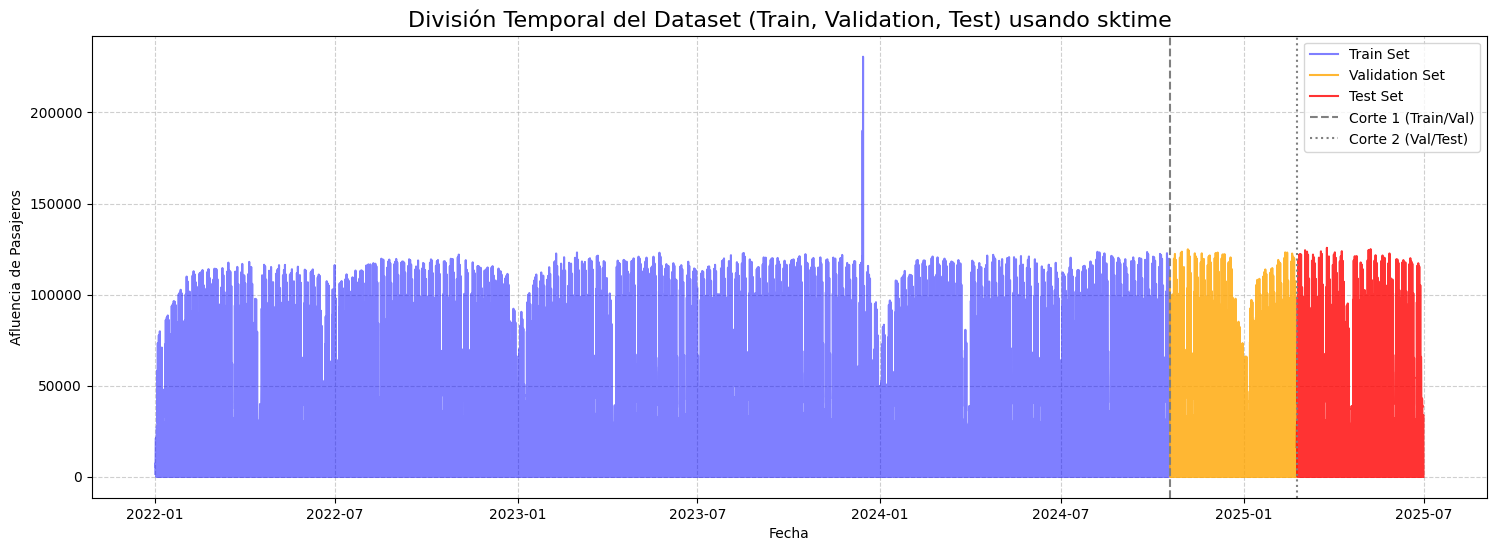

In [10]:
# =================================================================
# PLOT: Visualización de la División
# =================================================================


plt.figure(figsize=(18, 6))

# Usamos el índice de tiempo de los DataFrames de sktime
plt.plot(df_train.index, df_train['Número de pasajeros'], label='Train Set', alpha=0.5, color='blue')
plt.plot(df_val.index, df_val['Número de pasajeros'], label='Validation Set', alpha=0.8, color='orange')
plt.plot(df_test.index, df_test['Número de pasajeros'], label='Test Set', alpha=0.8, color='red')

# Líneas de corte
plt.axvline(x=df_val.index.min(), color='gray', linestyle='--', label='Corte 1 (Train/Val)')
plt.axvline(x=df_test.index.min(), color='gray', linestyle=':', label='Corte 2 (Val/Test)')

plt.title('División Temporal del Dataset (Train, Validation, Test) usando sktime', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Afluencia de Pasajeros')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Fase 2: -

In [ ]:
!pip install pmdarima

In [ ]:
# =================================================================
# IMPORTS PARA LA FASE 2 (MODELOS Y MÉTRICAS)
# =================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# NUEVO: auto_arima
from pmdarima import auto_arima

# Para que los gráficos se vean bonitos
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (14, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.6
plt.rcParams["font.size"] = 11


# =================================================================
# FUNCIÓN DE MÉTRICAS
# =================================================================

def calcular_metricas(y_true, y_pred, nombre_modelo="Modelo"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # ⬅⬅ aquí calculamos el RMSE "a mano"

    print(f"\n📊 Métricas - {nombre_modelo}")
    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")

    return {"modelo": nombre_modelo, "MAE": mae, "RMSE": rmse}


In [ ]:
# =================================================================
# PREPARACIÓN: SERIES Y VARIABLES EXÓGENAS
# =================================================================

# Serie objetivo (afluencia) para cada conjunto
y_train = df_train["Número de pasajeros"]
y_val   = df_val["Número de pasajeros"]
y_test  = df_test["Número de pasajeros"]

# Variable exógena (Es_Festivo) para cada conjunto
# La dejamos como DataFrame (2D) porque SARIMAX así lo prefiere.
X_train = df_train[["Es_Festivo"]]
X_val   = df_val[["Es_Festivo"]]
X_test  = df_test[["Es_Festivo"]]

# --- AÑADIDO: Asegurar que el índice tenga frecuencia para statsmodels ---
y_train = y_train.asfreq('H')
y_val = y_val.asfreq('H')
y_test = y_test.asfreq('H')
X_train = X_train.asfreq('H')
X_val = X_val.asfreq('H')
X_test = X_test.asfreq('H')

print("Tamaños:")
print("Train:", y_train.shape, X_train.shape)
print("Val  :", y_val.shape,   X_val.shape)
print("Test :", y_test.shape,  X_test.shape)


Tamaños:
Train: (24515,) (24515, 1)
Val  : (3064,) (3064, 1)
Test : (3065,) (3065, 1)


/tmp/ipython-input-1193956005.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_train = y_train.asfreq('H')
/tmp/ipython-input-1193956005.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_val = y_val.asfreq('H')
/tmp/ipython-input-1193956005.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_test = y_test.asfreq('H')
/tmp/ipython-input-1193956005.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  X_train = X_train.asfreq('H')
/tmp/ipython-input-1193956005.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  X_val = X_val.asfreq('H')
/tmp/ipython-input-1193956005.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  X_test = X_test.asfreq('H')


In [ ]:
# =================================================================
# FUNCIÓN: SELECCIONAR ORDEN CON AUTO_ARIMA
# =================================================================

def seleccionar_orden_auto_arima(
    y_train,
    X_train=None,
    m=7,
    seasonal=True,
    nombre_modelo="Modelo"
):
    """
    Usa auto_arima para encontrar los mejores (p,d,q) y (P,D,Q,m).
    - m: periodo estacional (7 si es semanal, 12 mensual, etc.)
    - seasonal=False -> ARIMA (sin parte estacional)
    """
    print(f"\n🔍 Buscando mejor modelo con auto_arima para {nombre_modelo}...")

    modelo_auto = auto_arima(
        y_train,
        exogenous=X_train,
        seasonal=seasonal,
        m=m,
        trace=True,                # imprime el proceso de búsqueda
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True,
        information_criterion="aic"
    )

    print("\n✅ Mejor modelo encontrado:")
    print(modelo_auto.summary())

    order = modelo_auto.order
    if seasonal:
        seasonal_order = modelo_auto.seasonal_order
    else:
        seasonal_order = (0, 0, 0, 0)

    print(f"\n👉 Orden no estacional (p,d,q): {order}")
    print(f"👉 Orden estacional (P,D,Q,m): {seasonal_order}")

    return order, seasonal_order


In [ ]:
# =================================================================
# FUNCIÓN PARA AJUSTAR, PREDECIR Y GRAFICAR
# =================================================================

def entrenar_y_graficar(
    y_train,
    y_val,
    X_train=None,
    X_val=None,
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0),
    nombre_modelo="Modelo",
    usar_pred_1paso=True
):
    """
    Ajusta un SARIMAX (sirve para ARIMA, SARIMA y SARIMAX),
    predice sobre el conjunto de validación y grafica el resultado.

    usar_pred_1paso=True -> usa get_prediction (1-paso hacia adelante),
    que suele seguir mejor la serie y no se ve tan 'recta'.
    """

    exog_train = X_train if X_train is not None else None
    exog_val   = X_val   if X_val   is not None else None

    print(f"\n🔧 Entrenando {nombre_modelo}...")
    modelo = SARIMAX(
        y_train,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
        freq='H' # <---- AÑADIDO: Forzar la frecuencia horaria
    )

    res = modelo.fit(disp=False)
    print(res.summary().tables[1])  # Tabla de coeficientes

    # =========================================================
    # PREDICCIÓN EN VALIDACIÓN
    # =========================================================
    if usar_pred_1paso:
        # Predicción 1-paso hacia adelante en el tramo de validación
        # For get_prediction with start/end, exog should cover only the prediction range
        start = y_val.index[0]
        end   = y_val.index[-1]

        if X_val is not None:
            pred = res.get_prediction(start=start, end=end, exog=X_val)
        else:
            pred = res.get_prediction(start=start, end=end)

        y_pred = pred.predicted_mean
        # aseguramos que el índice coincida con y_val
        y_pred = y_pred.reindex(y_val.index)

    else:
        # Forecast puro (multi-step) desde el final de y_train
        pred = res.get_forecast(steps=len(y_val), exog=exog_val)
        y_pred = pred.predicted_mean
        y_pred.index = y_val.index

    # Métricas
    met = calcular_metricas(y_val, y_pred, nombre_modelo)

    # Gráfico
    plt.figure(figsize=(14, 5))
    plt.plot(y_train.index, y_train, label="Train", alpha=0.6)
    plt.plot(y_val.index,   y_val,   label="Validación (Real)", linewidth=2)
    plt.plot(y_pred.index,  y_pred,  label=f"Predicción {nombre_modelo}", linewidth=2, linestyle="--")

    plt.axvline(y_val.index.min(), color="black", linestyle=":", linewidth=1)
    plt.title(f"Afluencia - {nombre_modelo}", fontsize=14)
    plt.xlabel("Fecha")
    plt.ylabel("Número de pasajeros")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return res, y_pred, met

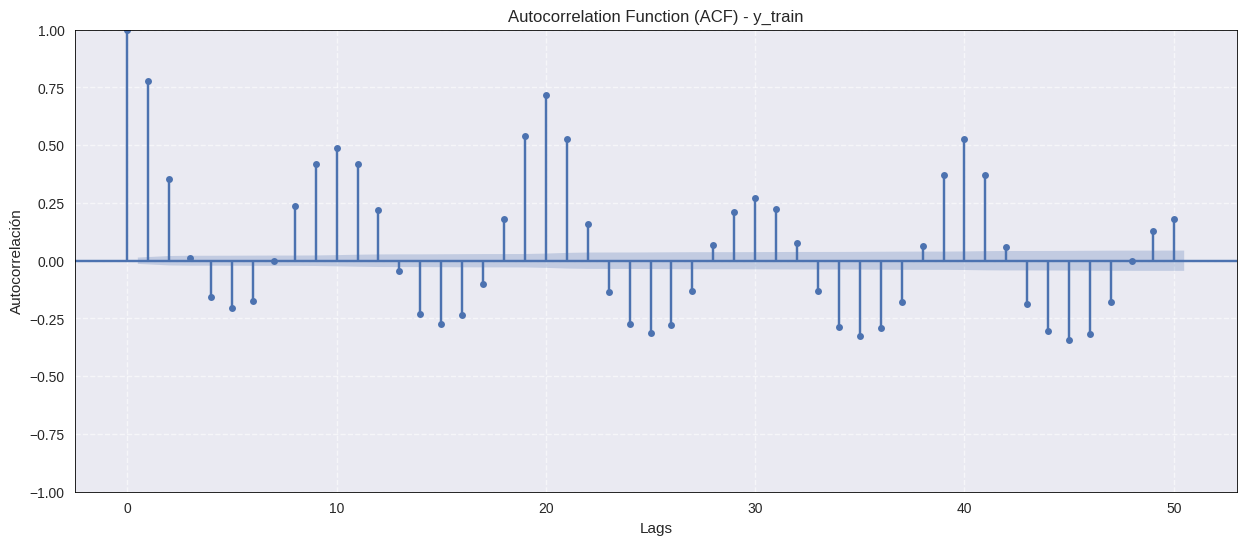

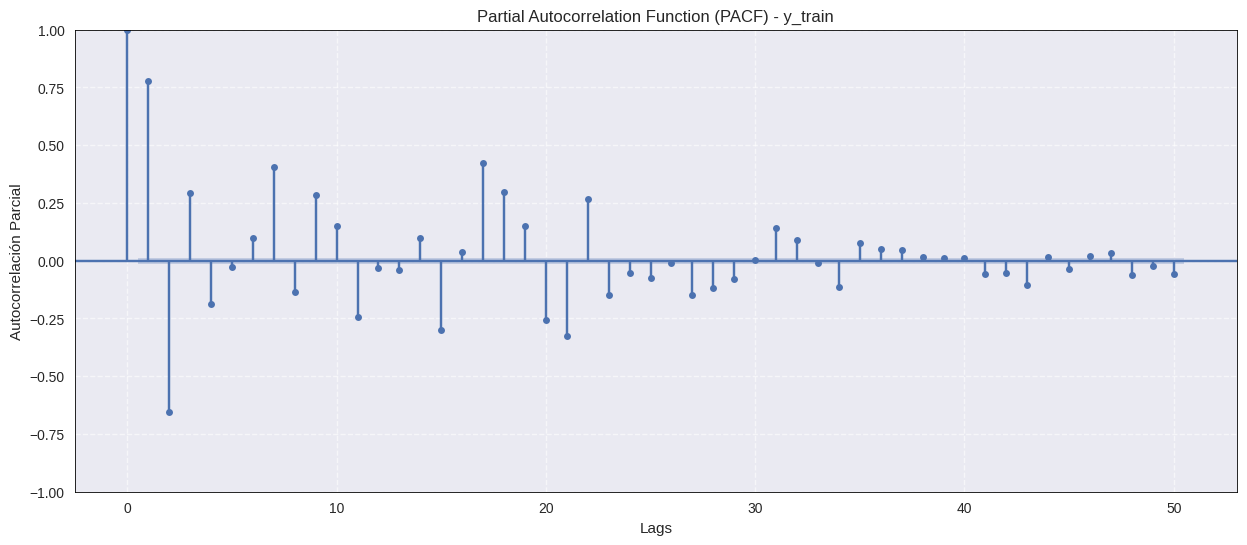

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# =================================================================
# VISUALIZACIÓN DE ACF Y PACF PARA DETERMINAR P Y Q
# =================================================================

# Gráfico ACF
plt.figure(figsize=(15, 6))
plot_acf(y_train, lags=50, ax=plt.gca(), title='Autocorrelation Function (ACF) - y_train')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Gráfico PACF
plt.figure(figsize=(15, 6))
plot_pacf(y_train, lags=50, ax=plt.gca(), title='Partial Autocorrelation Function (PACF) - y_train')
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# =================================================================
# DEFINICIÓN MANUAL DE ÓRDENES (p,d,q) SEGÚN SOLICITUD DEL USUARIO
# =================================================================

# --- ARIMA: Orden no estacional (5,1,0), sin parte estacional ---
orden_arima = (5, 1, 0)
orden_estacional_arima = (0, 0, 0, 0) # ARIMA no es estacional
print(f"Orden para ARIMA: no estacional={orden_arima}, estacional={orden_estacional_arima}")

# --- SARIMA: Orden no estacional (5,1,0), parte estacional por determinar o por defecto ---
orden_sarima = (5, 1, 0)
print(f"Orden para SARIMA: no estacional={orden_sarima}, estacional={orden_estacional_sar} (Default)")

# --- SARIMAX: Orden no estacional (5,1,0), parte estacional por determinar o por defecto ---
orden_sarimax = (5, 1, 0)
print(f"Orden para SARIMAX: no estacional={orden_sarimax}, estacional={orden_estacional_sarx} (Default)")

Orden para ARIMA: no estacional=(5, 1, 0), estacional=(0, 0, 0, 0)
Orden para SARIMA: no estacional=(5, 1, 0), estacional=(0, 0, 0, 7) (Default)
Orden para SARIMAX: no estacional=(5, 1, 0), estacional=(0, 0, 0, 7) (Default)



🔧 Entrenando ARIMA(5, 1, 0)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:595: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = to_offset(freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7794      0.006    140.944      0.000       0.769       0.790
ar.L2         -0.5308      0.007    -74.110      0.000      -0.545      -0.517
ar.L3          0.0358      0.009      4.071      0.000       0.019       0.053
ar.L4          0.0392      0.009      4.332      0.000       0.021       0.057
ar.L5         -0.1270      0.008    -16.098      0.000      -0.143      -0.112
sigma2      1.535e+08    2.7e-11   5.69e+18      0.000    1.53e+08    1.53e+08

📊 Métricas - ARIMA(5, 1, 0)
MAE : 32,909.49
RMSE: 38,361.93


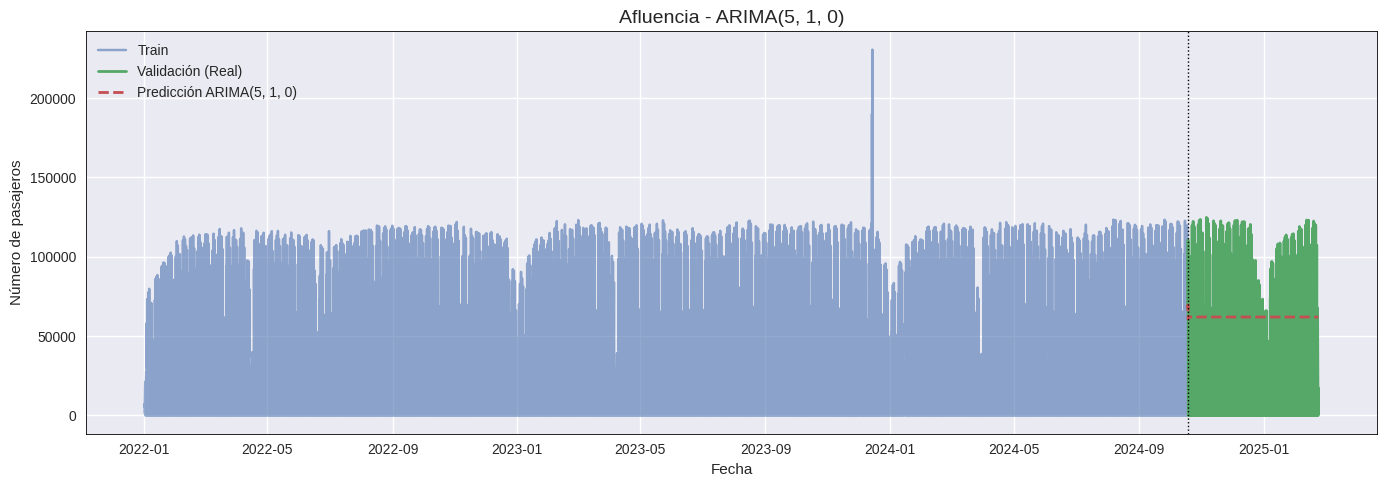

In [ ]:
# =================================================================
# MODELO 1: ARIMA (sin estacionalidad, sin exógenas)
# =================================================================

# Usando el orden definido previamente (5,1,0) y orden estacional (0,0,0,0)
# Se omite la llamada a seleccionar_orden_auto_arima()

modelo_arima, y_val_pred_arima, met_arima = entrenar_y_graficar(
    y_train=y_train,
    y_val=y_val,
    X_train=None,
    X_val=None,
    order=orden_arima,
    seasonal_order=orden_estacional_arima,
    nombre_modelo=f"ARIMA{orden_arima}",
    usar_pred_1paso=True   # para que se vea menos "recta"
)



🔧 Entrenando SARIMA(5, 1, 0)x(0, 0, 0, 7)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:595: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = to_offset(freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7794      0.006    140.944      0.000       0.769       0.790
ar.L2         -0.5308      0.007    -74.110      0.000      -0.545      -0.517
ar.L3          0.0358      0.009      4.071      0.000       0.019       0.053
ar.L4          0.0392      0.009      4.332      0.000       0.021       0.057
ar.L5         -0.1270      0.008    -16.098      0.000      -0.143      -0.112
sigma2      1.535e+08    2.7e-11   5.69e+18      0.000    1.53e+08    1.53e+08

📊 Métricas - SARIMA(5, 1, 0)x(0, 0, 0, 7)
MAE : 32,909.49
RMSE: 38,361.93


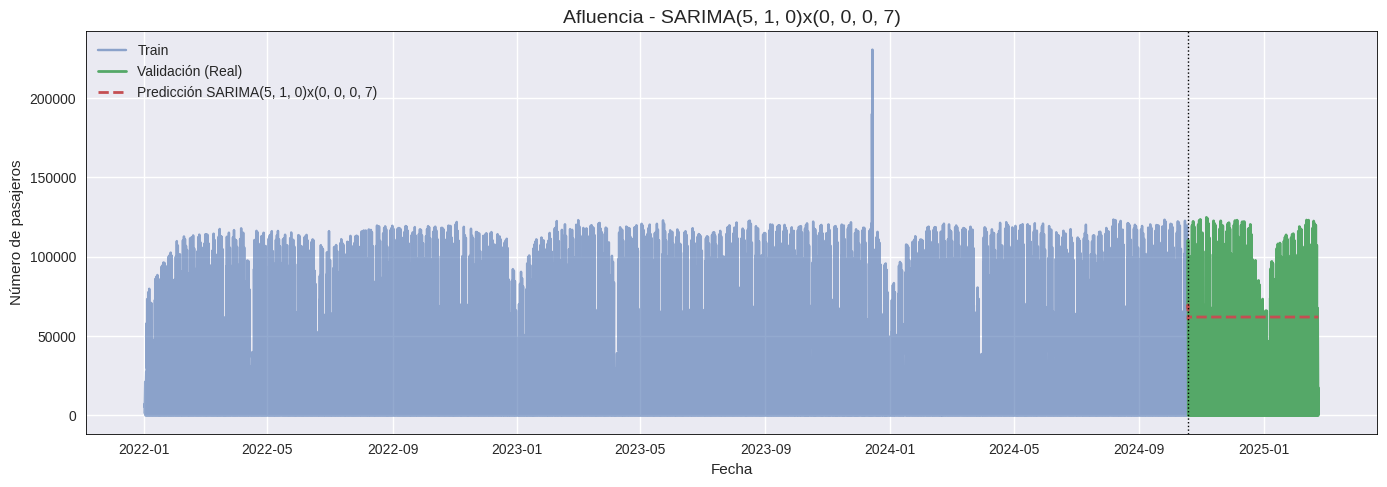

In [ ]:
# =================================================================
# MODELO 2: SARIMA (con estacionalidad, sin exógenas)
# =================================================================

# Usando el orden definido previamente (5,1,0) y orden estacional (0,0,0,7)
# Se omite la llamada a seleccionar_orden_auto_arima()

modelo_sarima, y_val_pred_sarima, met_sarima = entrenar_y_graficar(
    y_train=y_train,
    y_val=y_val,
    X_train=None,
    X_val=None,
    order=orden_sarima,
    seasonal_order=orden_estacional_sar,
    nombre_modelo=f"SARIMA{orden_sarima}x{orden_estacional_sar}",
    usar_pred_1paso=True
)



🔧 Entrenando SARIMAX(5, 1, 0)x(0, 0, 0, 7) + exog...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:595: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = to_offset(freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Es_Festivo -1.056e+04    673.202    -15.690      0.000   -1.19e+04   -9242.935
ar.L1          0.7757      0.006    139.436      0.000       0.765       0.787
ar.L2         -0.5274      0.007    -73.207      0.000      -0.541      -0.513
ar.L3          0.0325      0.009      3.708      0.000       0.015       0.050
ar.L4          0.0417      0.009      4.601      0.000       0.024       0.059
ar.L5         -0.1289      0.008    -16.290      0.000      -0.144      -0.113
sigma2      1.538e+08      0.034   4.59e+09      0.000    1.54e+08    1.54e+08

📊 Métricas - SARIMAX(5, 1, 0)x(0, 0, 0, 7) + exog
MAE : 32,376.92
RMSE: 37,791.82


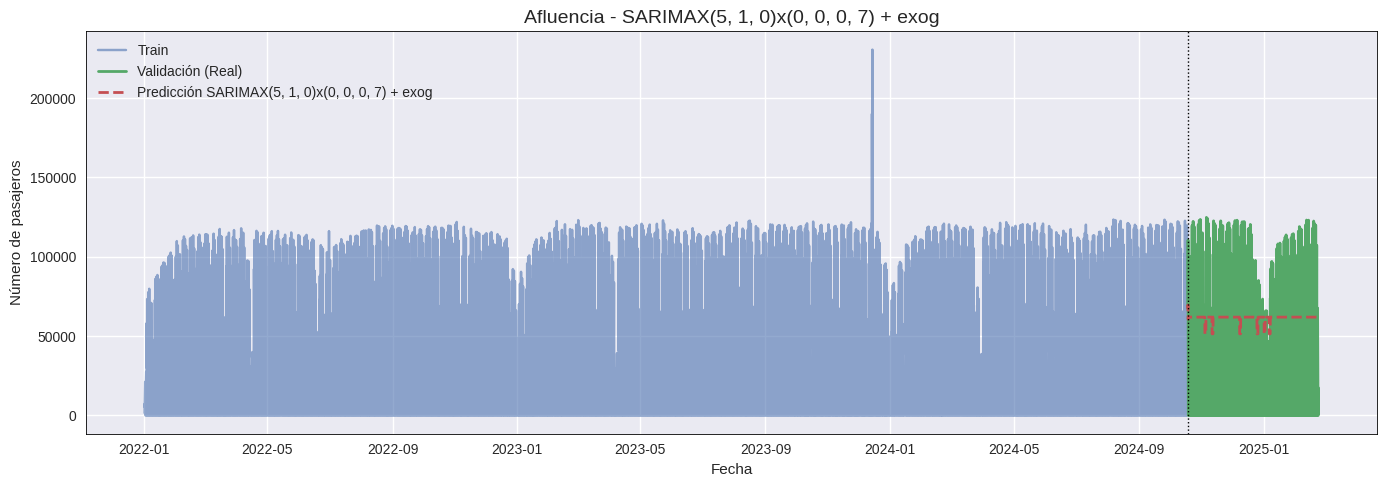

In [ ]:
# =================================================================
# MODELO 3: SARIMAX (estacional + Es_Festivo como exógena)
# =================================================================

# Usando el orden definido previamente (5,1,0) y orden estacional (0,0,0,7)
# Se omite la llamada a seleccionar_orden_auto_arima()

modelo_sarimax, y_val_pred_sarimax, met_sarimax = entrenar_y_graficar(
    y_train=y_train,
    y_val=y_val,
    X_train=X_train,
    X_val=X_val,
    order=orden_sarimax,
    seasonal_order=orden_estacional_sarx,
    nombre_modelo=f"SARIMAX{orden_sarimax}x{orden_estacional_sarx} + exog",
    usar_pred_1paso=True
)


In [ ]:
# =================================================================
# RESUMEN DE MÉTRICAS EN VALIDACIÓN
# =================================================================

resultados_val = pd.DataFrame([met_arima, met_sarima, met_sarimax])
resultados_val

,modelo,MAE,RMSE
0,"ARIMA(5, 1, 0)",32909.487813,38361.929088
1,"SARIMA(5, 1, 0)x(0, 0, 0, 7)",32909.487813,38361.929088
2,"SARIMAX(5, 1, 0)x(0, 0, 0, 7) + exog",32376.921672,37791.823961


In [ ]:
# =================================================================
# CROSS-VALIDATION PARA SERIES DE TIEMPO (WALK-FORWARD)
# =================================================================

def cross_val_sarimax(
    y,
    X=None,
    order=(2,1,2),
    seasonal_order=(0,0,0,0),
    n_splits=3,
    nombre_modelo="Modelo"
):
    """
    Realiza una validación cruzada temporal usando TimeSeriesSplit.
    En cada fold:
      - Entrena el modelo en el segmento de train.
      - Predice sobre el segmento de test del fold.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metricas_folds = []

    fold_num = 1
    for train_idx, test_idx in tscv.split(y):
        y_train_cv = y.iloc[train_idx]
        y_test_cv  = y.iloc[test_idx]

        if X is not None:
            X_train_cv = X.iloc[train_idx]
            X_test_cv  = X.iloc[test_idx]
        else:
            X_train_cv = None
            X_test_cv  = None

        # Entrenar modelo en el fold
        modelo = SARIMAX(
            y_train_cv,
            exog=X_train_cv,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = modelo.fit(disp=False)

        # Predecir el segmento de test de ese fold
        pred = res.get_forecast(steps=len(y_test_cv), exog=X_test_cv)
        y_pred_cv = pred.predicted_mean
        y_pred_cv.index = y_test_cv.index

        mae = mean_absolute_error(y_test_cv, y_pred_cv)
        # FIX: Calculate MSE first, then take square root for RMSE
        mse = mean_squared_error(y_test_cv, y_pred_cv)
        rmse = np.sqrt(mse)

        print(f"\nFold {fold_num} - {nombre_modelo}")
        print(f"Período train: {y_train_cv.index.min().date()} a {y_train_cv.index.max().date()}")
        print(f"Período test : {y_test_cv.index.min().date()} a {y_test_cv.index.max().date()}")
        print(f"MAE : {mae:,.2f}")
        print(f"RMSE: {rmse:,.2f}")

        metricas_folds.append({"fold": fold_num, "MAE": mae, "RMSE": rmse})
        fold_num += 1

    df_metricas = pd.DataFrame(metricas_folds)
    print(f"\n📌 Resumen {nombre_modelo} (CV sobre TRAIN):")
    print(df_metricas)
    print("\nPromedios:")
    print(df_metricas[["MAE","RMSE"]].mean())

    return df_metricas

In [ ]:
# =================================================================
# CROSS-VALIDATION PARA CADA MODELO
# =================================================================

cv_arima = cross_val_sarimax(
    y=y_train,
    X=None,
    order=orden_arima,
    seasonal_order=orden_estacional_arima,
    n_splits=3,
    nombre_modelo="ARIMA"
)

cv_sarima = cross_val_sarimax(
    y=y_train,
    X=None,
    order=orden_sarima,
    seasonal_order=orden_estacional_sar,
    n_splits=3,
    nombre_modelo="SARIMA"
)

cv_sarimax = cross_val_sarimax(
    y=y_train,
    X=X_train,
    order=orden_sarimax,
    seasonal_order=orden_estacional_sarx,
    n_splits=3,
    nombre_modelo="SARIMAX (con Es_Festivo)"
)


Fold 1 - ARIMA
Período train: 2022-01-01 a 2022-09-13
Período test : 2022-09-13 a 2023-05-26
MAE : 29,858.68
RMSE: 35,472.80

Fold 2 - ARIMA
Período train: 2022-01-01 a 2023-05-26
Período test : 2023-05-26 a 2024-02-06
MAE : 25,498.55
RMSE: 32,356.32

Fold 3 - ARIMA
Período train: 2022-01-01 a 2024-02-06
Período test : 2024-02-06 a 2024-10-18
MAE : 34,396.15
RMSE: 39,503.48

📌 Resumen ARIMA (CV sobre TRAIN):
   fold           MAE          RMSE
0     1  29858.679771  35472.795883
1     2  25498.546518  32356.319254
2     3  34396.149165  39503.481473

Promedios:
MAE     29917.791818
RMSE    35777.532203
dtype: float64

Fold 1 - SARIMA
Período train: 2022-01-01 a 2022-09-13
Período test : 2022-09-13 a 2023-05-26
MAE : 29,858.68
RMSE: 35,472.80

Fold 2 - SARIMA
Período train: 2022-01-01 a 2023-05-26
Período test : 2023-05-26 a 2024-02-06
MAE : 25,498.55
RMSE: 32,356.32

Fold 3 - SARIMA
Período train: 2022-01-01 a 2024-02-06
Período test : 2024-02-06 a 2024-10-18
MAE : 34,396.15
RMSE: 39,

Período Train+Val: 2022-01-01 -> 2025-02-23
Período Test      : 2025-02-23 -> 2025-06-30

📊 Métricas - Modelo Final SARIMAX (Train+Val -> Test)
MAE : 33,035.59
RMSE: 42,232.79


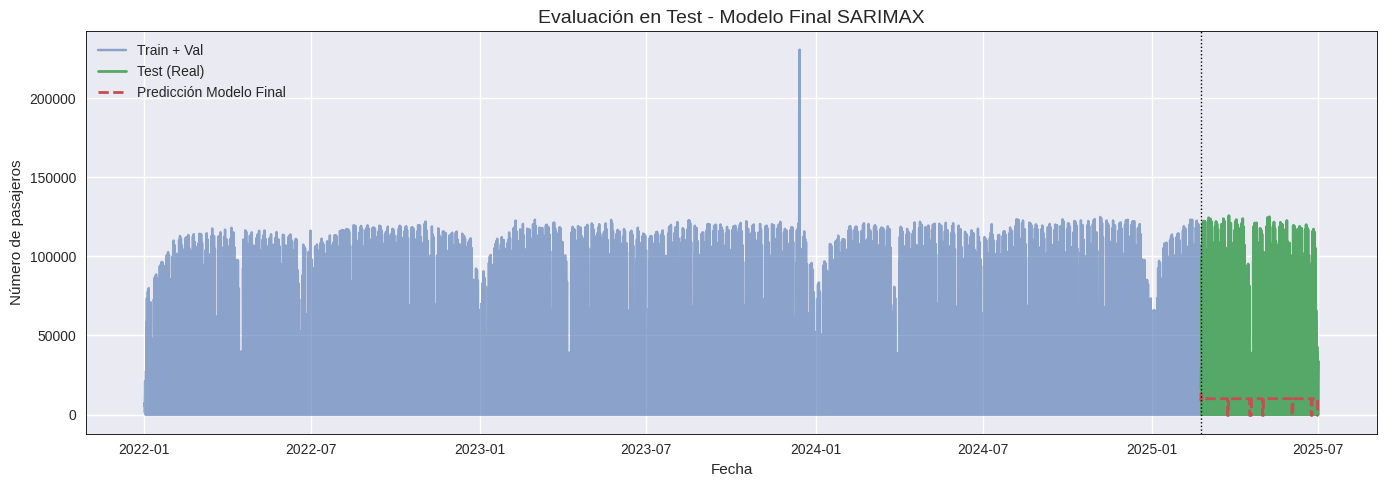

In [ ]:
# =================================================================
# MODELO FINAL: REENTRENAR CON TRAIN + VAL Y PROBAR EN TEST
# =================================================================

# Unimos train + val
y_trainval = pd.concat([y_train, y_val])
X_trainval = pd.concat([X_train, X_val])

print("Período Train+Val:", y_trainval.index.min().date(), "->", y_trainval.index.max().date())
print("Período Test      :", y_test.index.min().date(),     "->", y_test.index.max().date())

# Entrenamos el modelo final (SARIMAX con Es_Festivo y órdenes de auto_arima)
modelo_final = SARIMAX(
    y_trainval,
    exog=X_trainval,
    order=orden_sarimax,
    seasonal_order=orden_estacional_sarx,
    enforce_stationarity=False,
    enforce_invertibility=False
)

res_final = modelo_final.fit(disp=False)

# Predicción sobre el TEST (forecast puro)
pred_test = res_final.get_forecast(steps=len(y_test), exog=X_test)
y_test_pred = pred_test.predicted_mean
y_test_pred.index = y_test.index

# Métricas en TEST
met_test_final = calcular_metricas(y_test, y_test_pred, "Modelo Final SARIMAX (Train+Val -> Test)")

# Gráfico
plt.figure(figsize=(14, 5))
plt.plot(y_trainval.index, y_trainval, label="Train + Val", alpha=0.6)
plt.plot(y_test.index,     y_test,     label="Test (Real)", linewidth=2)
plt.plot(y_test_pred.index,y_test_pred,label="Predicción Modelo Final", linewidth=2, linestyle="--")

plt.axvline(y_test.index.min(), color="black", linestyle=":", linewidth=1)
plt.title("Evaluación en Test - Modelo Final SARIMAX", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Número de pasajeros")
plt.legend()
plt.tight_layout()
plt.show()

## Fase 3: Modelos de machine learning (Random Forest y XGBoost)

### 3.1 Extracción de características

In [14]:
!pip install tsfresh
import pandas as pd
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

In [34]:
from sktime.forecasting.model_selection import temporal_train_test_split

# =================================================================
# PREPARACIÓN: Preparación de Datos y Filtro Post-Pandemia
# =================================================================

# Fecha de inicio de modelado (excluyendo la anomalía 2020-2021)
FECHA_INICIO = pd.to_datetime('2022-01-01 00:00:00')

# Filtramos el DataFrame para el modelado
df_modelo_filtered = df_consolidado[df_consolidado['Fecha_dt'] >= FECHA_INICIO_MODELO].copy()

df_modelo_filtered.set_index('Fecha_dt', inplace=True)
df_modelo_filtered.sort_index(inplace=True)

# =================================================================
# SPLIT: Implementación del Triple Split con sktime (Train / Validation / Test)
# =================================================================

# --- PASO 1: Dividir en Train y un Conjunto Final ---
# Usamos el 80% para Training y el 20% para la evaluación reciente.
# El parámetro test_size=0.2 le dice a sktime que reserve el 20% más reciente para el Test.

df_train_base, df_final_set = temporal_train_test_split(
    df_modelo_filtered,
    test_size=0.2  # 20% para el conjunto de evaluación reciente
)

# --- PASO 2: Dividir el Conjunto Final en Validation y Test ---
# Usamos 50% para Validation y 50% para Test (cada uno será 10% del total original).
# Aquí, test_size=0.5 le dice a sktime que tome el 50% más reciente del df_final_set.

df_val, df_test = temporal_train_test_split(
    df_final_set,
    test_size=0.5  # 50% de df_final_set será el Test Set (el más reciente)
)

# El df_train final incluye los datos base:
df_train = df_train_base.copy()

# 3. Validación y Resumen de los Splits
print(f"✅ Triple Split Temporal realizado usando sktime.")
print("-" * 70)
print(f"| Período Modelado: {df_modelo_filtered.index.min().date()} a {df_modelo_filtered.index.max().date()}")
print("-" * 70)
print(f"| TRAIN Set (80% del inicio) | Tamaño: {len(df_train):,} | Período hasta: {df_train.index.max().date()}")
print(f"| VALIDATION Set (10% intermedio) | Tamaño: {len(df_val):,} | Período: {df_val.index.min().date()} a {df_val.index.max().date()}")
print(f"| TEST Set (10% más reciente) | Tamaño: {len(df_test):,} | Período: {df_test.index.min().date()} a {df_test.index.max().date()}")
print("-" * 70)

✅ Triple Split Temporal realizado usando sktime.
----------------------------------------------------------------------
| Período Modelado: 2022-01-01 a 2025-06-30
----------------------------------------------------------------------
| TRAIN Set (80% del inicio) | Tamaño: 240,240 | Período hasta: 2024-10-19
| VALIDATION Set (10% intermedio) | Tamaño: 30,030 | Período: 2024-10-19 a 2025-02-22
| TEST Set (10% más reciente) | Tamaño: 30,030 | Período: 2025-02-22 a 2025-06-30
----------------------------------------------------------------------


In [36]:
# Para el conjunto de entrenamiento (df_train)
# 1. Seleccionar las columnas relevantes y hacer una copia
df_tsfresh_ready = df_train[['Línea de servicio', 'Fecha', 'Número de pasajeros', 'Es_Festivo']].copy()

# 2. Renombrar las columnas al formato esperado por tsfresh
df_tsfresh_ready = df_tsfresh_ready.rename(columns={
    'Línea de servicio': 'id',
    'Fecha': 'time',
    'Número de pasajeros': 'value'
})

In [37]:
# Convertir la columna 'time' a formato datetime si no lo está
df_tsfresh_ready['time'] = pd.to_datetime(
    df_tsfresh_ready['time'],
    dayfirst=True
)

In [38]:
from tsfresh.feature_extraction import MinimalFCParameters

# Extracción de Features
# 1. Definir los parámetros de extracción (solo los más esenciales)
extraction_settings = MinimalFCParameters()

# 2. Aplicar la extracción con los parámetros reducidos
extracted_features = extract_features(
    df_tsfresh_ready,
    column_id="id",
    column_sort="time",
    default_fc_parameters=extraction_settings,
    impute_function=impute, # Para manejar NaNs después de la extracción
    show_warnings=False,
    n_jobs=0 # Evitar problemas de paralelismo
)

Feature Extraction: 100%|██████████| 24/24 [00:00<00:00, 535.90it/s]


In [39]:
# Para el conjunto de validación (df_val)
# 1. Seleccionar las columnas relevantes y hacer una copia
df_tsfresh_ready_val = df_val[['Línea de servicio', 'Fecha', 'Número de pasajeros', 'Es_Festivo']].copy()

# 2. Renombrar las columnas al formato esperado por tsfresh
df_tsfresh_ready_val = df_tsfresh_ready_val.rename(columns={
    'Línea de servicio': 'id',
    'Fecha': 'time',
    'Número de pasajeros': 'value'
})

In [40]:
# Convertir la columna 'time' a formato datetime si no lo está
df_tsfresh_ready_val['time'] = pd.to_datetime(
    df_tsfresh_ready_val['time'],
    dayfirst=True
)

In [41]:
# Extracción de Features
# 1. Definir los parámetros de extracción (solo los más esenciales)
extraction_settings = MinimalFCParameters()

# 2. Aplicar la extracción con los parámetros reducidos
extracted_features_val = extract_features(
    df_tsfresh_ready_val,
    column_id="id",
    column_sort="time",
    default_fc_parameters=extraction_settings,
    impute_function=impute, # Para manejar NaNs después de la extracción
    show_warnings=False,
    n_jobs=0 # Evitar problemas de paralelismo
)

Feature Extraction: 100%|██████████| 24/24 [00:00<00:00, 1975.03it/s]


In [42]:
# Para el conjunto de prueba (df_test)
# 1. Seleccionar las columnas relevantes y hacer una copia
df_tsfresh_ready_test = df_test[['Línea de servicio', 'Fecha', 'Número de pasajeros', 'Es_Festivo']].copy()

# 2. Renombrar las columnas al formato esperado por tsfresh
df_tsfresh_ready_test = df_tsfresh_ready_test.rename(columns={
    'Línea de servicio': 'id',
    'Fecha': 'time',
    'Número de pasajeros': 'value'
})

In [43]:
# Convertir la columna 'time' a formato datetime si no lo está
df_tsfresh_ready_test['time'] = pd.to_datetime(
    df_tsfresh_ready_test['time'],
    dayfirst=True
)

In [44]:
# Extracción de Features
# 1. Definir los parámetros de extracción (solo los más esenciales)
extraction_settings = MinimalFCParameters()

# 2. Aplicar la extracción con los parámetros reducidos
extracted_features_test = extract_features(
    df_tsfresh_ready_test,
    column_id="id",
    column_sort="time",
    default_fc_parameters=extraction_settings,
    impute_function=impute, # Para manejar NaNs después de la extracción
    show_warnings=False,
    n_jobs=0 # Evitar problemas de paralelismo
)

Feature Extraction: 100%|██████████| 24/24 [00:00<00:00, 1923.70it/s]


### 3.2 Lag features (Retrasos)

In [45]:
# LAG FEATURES
# Columna de interés
COLUMNA_VALOR = 'Número de pasajeros'

# Desfases a crear
lags = [1, 2, 7]

# df nuevos para extracción de características
df_train_ec = df_train.copy()
df_val_ec = df_val.copy()
df_test_ec = df_test.copy()

In [46]:
def crear_lag_features(df, columna, lags_list, id_col='Línea de servicio'):
    """Crea variables de desfase (Lag Features) para múltiples series de tiempo."""

    # 1. Agrupar por el ID de la serie (Linea_ID)
    grouped = df.groupby(id_col)

    for lag in lags_list:
        # 2. Aplicar shift() DENTRO de cada grupo
        df[f'{columna}_lag_{lag}'] = grouped[columna].transform(
            lambda x: x.shift(lag)
        )

    return df

# Aplicar la función a los conjuntos de datos
df_train_ec = crear_lag_features(df_train_ec, COLUMNA_VALOR, lags)
df_val_ec = crear_lag_features(df_val_ec, COLUMNA_VALOR, lags)
df_test_ec = crear_lag_features(df_test_ec, COLUMNA_VALOR, lags)

### 3.3 Rolling Windows (Ventanas móviles)

In [47]:
# ROLLING WINDOWS
import numpy as np

def limpiar_y_convertir(df, columna):
    """Convierte la columna a tipo numérico, forzando errores a NaN."""

    # 1. Aplicar pd.to_numeric con errors='coerce'
    df[columna] = pd.to_numeric(df[columna], errors='coerce')

    # 2. Rellenamos los NaN con cero o un valor adecuado (usaremos 0 por simplicidad)
    df[columna] = df[columna].fillna(0)

    # 3. Forzamos a tipo entero si es posible, o float
    df[columna] = df[columna].astype(float)

    return df

# Aplicar la limpieza y conversión a los tres sets
df_train_ec = limpiar_y_convertir(df_train_ec, COLUMNA_VALOR)
df_val_ec = limpiar_y_convertir(df_val_ec, COLUMNA_VALOR)
df_test_ec = limpiar_y_convertir(df_test_ec, COLUMNA_VALOR)

In [48]:
def crear_rolling_features_directo(df, columna, windows_list, stats_list, id_col='Línea de servicio'):
    """Crea variables de Ventanas Móviles por grupo, aplicando la estadística directamente."""

    # Trabajamos sobre una copia para evitar SettingWithCopyWarning y asegurar la pureza del DF
    temp_df = df.copy()

    for window in windows_list:
        for stat in stats_list:

            new_col_name = f'{columna}_roll{window}_{stat}'

            # Aplicar la operación dentro de transform().
            # La función lambda recibe la Serie 'x' del grupo actual.
            if stat == 'mean':
                temp_df[new_col_name] = temp_df.groupby(id_col)[columna].transform(
                    lambda x: x.rolling(window=window, min_periods=1).mean()
                )
            elif stat == 'std':
                temp_df[new_col_name] = temp_df.groupby(id_col)[columna].transform(
                    lambda x: x.rolling(window=window, min_periods=1).std()
                )
            elif stat == 'min':
                temp_df[new_col_name] = temp_df.groupby(id_col)[columna].transform(
                    lambda x: x.rolling(window=window, min_periods=1).min()
                )
            elif stat == 'max':
                temp_df[new_col_name] = temp_df.groupby(id_col)[columna].transform(
                    lambda x: x.rolling(window=window, min_periods=1).max()
                )

    return temp_df

In [49]:
windows = [3, 7]
stats = ['mean', 'std', 'min', 'max']

# Usar la función directa:
df_train_ec = crear_rolling_features_directo(df_train_ec, COLUMNA_VALOR, windows, stats)
df_val_ec = crear_rolling_features_directo(df_val_ec, COLUMNA_VALOR, windows, stats)
df_test_ec = crear_rolling_features_directo(df_test_ec, COLUMNA_VALOR, windows, stats)

### 3.4 Manejo y gestión de NaN

In [50]:
import pandas as pd
# Columna que identifica a cada serie de tiempo
ID_COL = 'Línea de servicio'

def imputar_con_loop(df, id_col=ID_COL):
    """
    Imputación con ffill usando un bucle explícito por grupo (más seguro
    contra la pérdida de columnas ID).
    """

    # Aseguramos que la columna ID exista antes de agrupar. Si no existe, no podemos continuar.
    if id_col not in df.columns:
        print(f"ERROR FATAL: La columna de ID '{id_col}' no se encuentra en el DataFrame.")
        return df

    unique_ids = df[id_col].unique()
    imputed_dfs = []

    for line_id in unique_ids:
        # Seleccionar la sub-serie
        subset = df[df[id_col] == line_id].copy()

        # Aplicar Forward Fill a la sub-serie (solo en las columnas de features)
        # Excluir la columna ID_COL y aplicar ffill()
        subset.iloc[:, :] = subset.ffill() # Aplica ffill a todas las columnas

        imputed_dfs.append(subset)

    # Concatenar todos los DataFrames imputados y ordenar por el índice original
    df_final = pd.concat(imputed_dfs).sort_index()

    return df_final

# Aplicación
df_train_final_ef = imputar_con_loop(df_train_ec)
df_val_final_ef = imputar_con_loop(df_val_ec)
df_test_final_ef = imputar_con_loop(df_test_ec)

In [51]:
# Identifica todas las columnas que son texto, fechas o identificadores de tiempo/categoría.
COLUMNAS_A_EXCLUIR = [
    ID_COL,
    'Fecha_dt',
    'Fecha',
    'Día_Semana',
    'Hora'
]

# 1. Excluimos tanto el ID como las columnas de tiempo/categoría.
train_means = df_train_final_ef.drop(columns=COLUMNAS_A_EXCLUIR, errors='ignore').mean()

# --- Aplicar las medias a los tres sets ---
df_train_final_ef = df_train_final_ef.fillna(train_means)
df_val_final_ef = df_val_final_ef.fillna(train_means)
df_test_final_ef = df_test_final_ef.fillna(train_means)

### 3.5 Combinación de características

In [52]:
# --- Combinación de Features ---
extracted_features.reset_index(inplace=True)

# 1. Renombrar el índice a la columna ID_COL si es necesario (si tsfresh lo dejó como índice)
if extracted_features.index.name != ID_COL:
    extracted_features = extracted_features.reset_index().rename(columns={'index': ID_COL})

In [53]:
extracted_features_val.reset_index(inplace=True)

if extracted_features_val.index.name != ID_COL:
    extracted_features_val = extracted_features_val.reset_index().rename(columns={'index': ID_COL})

In [54]:
extracted_features_test.reset_index(inplace=True)

if extracted_features_test.index.name != ID_COL:
    extracted_features_test = extracted_features_test.reset_index().rename(columns={'index': ID_COL})

In [55]:
# 2. Eliminar columnas redundantes (como la columna 'id' que tsfresh pudo haber mantenido)
# Lista de DataFrames a limpiar
datasets = [extracted_features, extracted_features_val, extracted_features_test]
nombre_columna_redundante = 'level_0'

for df in datasets:
    if nombre_columna_redundante in df.columns:
        df.drop(columns=[nombre_columna_redundante], inplace=True)
        print(f"Columna '{nombre_columna_redundante}' eliminada del DataFrame.")
    else:
        print(f"La columna '{nombre_columna_redundante}' no se encontró en el DataFrame.")

Columna 'level_0' eliminada del DataFrame.
Columna 'level_0' eliminada del DataFrame.
Columna 'level_0' eliminada del DataFrame.


In [56]:
# Lista de DataFrames de features de tsfresh para validación y prueba

# --- FUNCIÓN DE MERGE ---
def merge_tsfresh_features(df_original, tsfresh_df, id_col='Línea de servicio'):
    """
    Fusiona features, asegurando que el ID sea una columna única.
    """

    # 1. Preparar el DataFrame Original (Lado Izquierdo)
    df_original = df_original.copy()

    # 2. Preparar el DataFrame de Features (Lado Derecho)
    tsfresh_df = tsfresh_df.copy()

    # Asegurar que el ID sea la primera columna
    if tsfresh_df.columns[0] != id_col:
        tsfresh_df = tsfresh_df.rename(columns={tsfresh_df.columns[0]: id_col})

    tsfresh_df = tsfresh_df.reset_index(drop=False)

    # 3. Realizar el merge
    df_merged = pd.merge(
        df_original,
        tsfresh_df,
        how='left',
        on=id_col
    )
    return df_merged

# --- APLICACIÓN ---
# 1. Entrenamiento
df_train_final = merge_tsfresh_features(df_train_final_ef, extracted_features)

# 2. Validación
df_val_final = merge_tsfresh_features(df_val_final_ef, extracted_features_val)

# 3. Prueba
df_test_final = merge_tsfresh_features(df_test_final_ef, extracted_features_test)

### 3.6 Entrenamiento de modelos

In [57]:
# Columna objetivo
TARGET = 'Número de pasajeros'

# Features (excluyendo el target, la columna ID, la fecha y el día de la semana)
ID_COLUMN = 'Línea de servicio'
EXCLUDE_COLS = [TARGET, ID_COLUMN, 'Fecha', 'Día_Semana']

# 1. Entrenamiento
X_train = df_train_final.drop(columns=EXCLUDE_COLS, errors='ignore')
y_train = df_train_final[TARGET]

# 2. Validación (Para ajuste de hiperparámetros si es necesario)
X_val = df_val_final.drop(columns=EXCLUDE_COLS, errors='ignore')
y_val = df_val_final[TARGET]

# 3. Prueba (Para evaluación final)
X_test = df_test_final.drop(columns=EXCLUDE_COLS, errors='ignore')
y_test = df_test_final[TARGET]

print("Preparación de datos completada. Tenemos:", len(X_train), "muestras de entrenamiento.")

Preparación de datos completada. Tenemos: 240240 muestras de entrenamiento.


#### 3.6.1 Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Inicialización y entrenamiento del modelo
rf_model = RandomForestRegressor(
    n_estimators=500,        # Alto número de árboles para mayor robustez
    max_depth=10,            # Profundidad limitada para evitar sobreajuste extremo
    random_state=42,
    n_jobs=-1
)

print("\nEntrenando Random Forest Regressor...")
rf_model.fit(X_train, y_train)
print("Entrenamiento completado.")

# Evaluación en el conjunto de validación
rf_predictions = rf_model.predict(X_val)
rf_mse = mean_squared_error(y_val, rf_predictions)
rf_rmse = np.sqrt(rf_mse)

print("\n--- Resultados de Random Forest Regressor ---")
print(f"Mean Squared Error (MSE) en Validación: {rf_mse:.2f}")
print(f"Root Mean Squared Error (RMSE) en Validación: {rf_rmse:.2f}")

#### 3.6.2 XGBoost

In [ ]:
import xgboost as xgb

# Inicialización y entrenamiento del modelo
xgb_model = xgb.XGBRegressor(
    n_estimators=10000,
    learning_rate=0.01,         # Tasa de aprendizaje pequeña para pasos cautelosos
    max_depth=5,
    objective='reg:squarederror', # Objetivo para regresión
    eval_metric='rmse',           # Métrica de evaluación para early stopping
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50, # Detener si no mejora en 50 iteraciones
)

print("\nEntrenando XGBoost Regressor...")
xgb_model.fit(
    X_train, y_train,
    # Para la parada temprana
    eval_set=[(X_val, y_val)],
    verbose=False
)
print(f"Entrenamiento completado en {xgb_model.best_iteration} rondas.")

# Evaluación en el conjunto de validación
xgb_predictions = xgb_model.predict(X_val)
xgb_mse = mean_squared_error(y_val, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)

print("\n--- Resultados de XGBoost Regressor ---")
print(f"Mean Squared Error (MSE) en Validación: {xgb_mse:.2f}")
print(f"Root Mean Squared Error (RMSE) en Validación: {xgb_rmse:.2f}")

#### 3.6.3 Guardar modelos iniciales

In [ ]:
import joblib
import os

# Definir una carpeta local
MODEL_DIR = 'modelos_entrenados'
os.makedirs(MODEL_DIR, exist_ok=True)

# 1. Guardar Random Forest Regressor
rf_filename = os.path.join(MODEL_DIR, 'random_forest_regressor.joblib')
joblib.dump(rf_model, rf_filename)
print(f"✅ Random Forest guardado en: {rf_filename}")

# 2. Guardar XGBoost Regressor
xgb_filename = os.path.join(MODEL_DIR, 'xgboost_regressor.joblib')
joblib.dump(xgb_model, xgb_filename)
print(f"✅ XGBoost guardado en: {xgb_filename}")

In [ ]:
from google.colab import drive
import shutil

# 1. Montar Google Drive
drive.mount('/content/drive')
print("Drive montado. Búscalo en /content/drive/MyDrive")

# 2. Definir la ruta de destino en Drive
DRIVE_PATH = '/content/drive/MyDrive/Mis_Modelos_ML'
os.makedirs(DRIVE_PATH, exist_ok=True)

# 3. Mover los modelos de la carpeta temporal a Google Drive
shutil.move(rf_filename, os.path.join(DRIVE_PATH, os.path.basename(rf_filename)))
shutil.move(xgb_filename, os.path.join(DRIVE_PATH, os.path.basename(xgb_filename)))

print(f"✅ Modelos movidos a Drive: {DRIVE_PATH}")

In [11]:
# Cargue de modelos iniciales y evaluación de métricas
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import joblib
import os

DRIVE_PATH = '/content/drive/MyDrive/Mis_Modelos_ML'

rf_model_cargado = joblib.load(os.path.join(DRIVE_PATH, 'random_forest_regressor.joblib'))
xgb_model_cargado = joblib.load(os.path.join(DRIVE_PATH, 'xgboost_regressor.joblib'))

print("Modelos cargados y listos para hacer predicciones.")

Modelos cargados y listos para hacer predicciones.


/usr/lib/python3.12/pickle.py:1760: UserWarning: [21:37:54] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [59]:
# Evaluación final de métricas de ambos modelos iniciales
from sklearn.metrics import mean_squared_error

# Para random forest
# Evaluación en el conjunto de validación
rf_predictions_loaded = rf_model_cargado.predict(X_val)
rf_mse_loaded = mean_squared_error(y_val, rf_predictions_loaded)
rf_rmse_loaded = np.sqrt(rf_mse_loaded)

In [60]:
print("\n--- Resultados de Random Forest Regressor ---")
print(f"Mean Squared Error (MSE) en Validación: {rf_mse_loaded:.2f}")
print(f"Root Mean Squared Error (RMSE) en Validación: {rf_rmse_loaded:.2f}")


--- Resultados de Random Forest Regressor ---
Mean Squared Error (MSE) en Validación: 187178.96
Root Mean Squared Error (RMSE) en Validación: 432.64


In [61]:
# Para XGBoost
# Evaluación en el conjunto de validación
xgb_predictions_load = xgb_model_cargado.predict(X_val)
xgb_mse_load = mean_squared_error(y_val, xgb_predictions_load)
xgb_rmse_load = np.sqrt(xgb_mse_load)

print("\n--- Resultados de XGBoost Regressor ---")
print(f"Mean Squared Error (MSE) en Validación: {xgb_mse_load:.2f}")
print(f"Root Mean Squared Error (RMSE) en Validación: {xgb_rmse_load:.2f}")


--- Resultados de XGBoost Regressor ---
Mean Squared Error (MSE) en Validación: 153600.69
Root Mean Squared Error (RMSE) en Validación: 391.92


### 3.6.4 Ajuste de hiperparámetros al mejor modelo (XGBoost)

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# 1. Definir la métrica objetivo: Minimizar el RMSE.
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# 2. Definir la cuadrícula de parámetros a explorar
param_dist = {
    'n_estimators': np.arange(500, 2501, 100),  # De 500 a 2000, pasos de 100
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': np.arange(3, 11),  # De 3 a 10
    'subsample': np.arange(0.6, 1.0, 0.1), # 0.6, 0.7, 0.8, 0.9, 1.0
    'colsample_bytree': np.arange(0.6, 1.0, 0.1),
    'gamma': [0, 0.1, 0.5, 1], # Parámetro de regularización
}

In [ ]:
# 3. Inicializar el modelo base de XGBoost
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1,
    # Estos se ajustarán por el CV, pero definimos los que no queremos buscar
    tree_method='hist'
)

# 4. Configurar RandomizedSearchCV
# n_iter: Número de combinaciones a probar (cuanto más alto, más lento pero mejor)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50, # 50 combinaciones aleatorias
    scoring=rmse_scorer,
    cv=3, # Usa 3-Fold Cross-Validation en X_train
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print(f"Iniciando Randomized Search (probando {50} combinaciones)...")

# 5. Ejecutar la búsqueda en los datos de entrenamiento
# Usamos el conjunto de entrenamiento (X_train, y_train)
# La Validación Cruzada interna se encarga de la validación
random_search.fit(X_train, y_train)

print("Búsqueda completada.")

In [ ]:
# 6. Mostrar los mejores resultados
best_score = -random_search.best_score_ # Convertir a valor positivo (MSE)
best_rmse = np.sqrt(best_score)

print("\n--- Resultados de la Búsqueda ---")
print(f"Mejor MSE (en CV de Entrenamiento): {best_score:.4f}")
print(f"Mejor RMSE (en CV de Entrenamiento): {best_rmse:.4f}")
print("Mejores Hiperparámetros encontrados:")
print(random_search.best_params_)

# 7. Guardar el mejor modelo
best_xgb_model = random_search.best_estimator_

xgb_best_model_filename = os.path.join(MODEL_DIR, 'best_xgboost_regressor.joblib')
joblib.dump(best_xgb_model, xgb_best_model_filename)
print(f"✅ Best XGBoost guardado en: {xgb_best_model_filename}")

In [ ]:
shutil.move(xgb_best_model_filename, os.path.join(DRIVE_PATH, os.path.basename(xgb_best_model_filename)))

print(f"✅ Modelos movidos a Drive: {DRIVE_PATH}")

In [62]:
# Cargamos el mejor modelo tras el ajuste de hiperparámetros

best_xgb_model_cargado = joblib.load(os.path.join(DRIVE_PATH, 'best_xgboost_regressor.joblib'))

print("Modelo cargado y listo para hacer predicciones.")

Modelo cargado y listo para hacer predicciones.


In [63]:
# Evaluación en el conjunto de validación
best_xgb_predictions_load = best_xgb_model_cargado.predict(X_val)
best_xgb_mse_load = mean_squared_error(y_val, best_xgb_predictions_load)
best_xgb_rmse_load = np.sqrt(best_xgb_mse_load)

print("\n--- Resultados del mejor XGBoost Regressor ---")
print(f"Mean Squared Error (MSE) en Validación: {best_xgb_mse_load:.2f}")
print(f"Root Mean Squared Error (RMSE) en Validación: {best_xgb_rmse_load:.2f}")


--- Resultados del mejor XGBoost Regressor ---
Mean Squared Error (MSE) en Validación: 84501.09
Root Mean Squared Error (RMSE) en Validación: 290.69


### 3.7 Evaluación final del mejor modelo en el conjunto de prueba

In [ ]:
from sklearn.metrics import mean_squared_error

final_predictions = best_xgb_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("\n--- Evaluación Final en Conjunto de Prueba ---")
print(f"RMSE Final del Modelo Optimizado: {final_rmse:.4f}")

In [64]:
# Con el modelo cargado

final_predictions_load = best_xgb_model_cargado.predict(X_test)
final_mse_load = mean_squared_error(y_test, final_predictions_load)
final_rmse_load = np.sqrt(final_mse_load)

print("\n--- Evaluación Final en Conjunto de Prueba ---")
print(f"Mean Squared Error (MSE) en Validación: {final_mse_load:.2f}")
print(f"RMSE Final del Modelo Optimizado: {final_rmse_load:.4f}")


--- Evaluación Final en Conjunto de Prueba ---
Mean Squared Error (MSE) en Validación: 86856.19
RMSE Final del Modelo Optimizado: 294.7137


### 3.8 Visualización e interpretación de resultados

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crear un DataFrame para la visualización

df_plot = df_test_final[[ID_COLUMN, 'Fecha', TARGET]].copy()
df_plot['Predicción'] = final_predictions_load
df_plot['Target Real'] = y_test.values

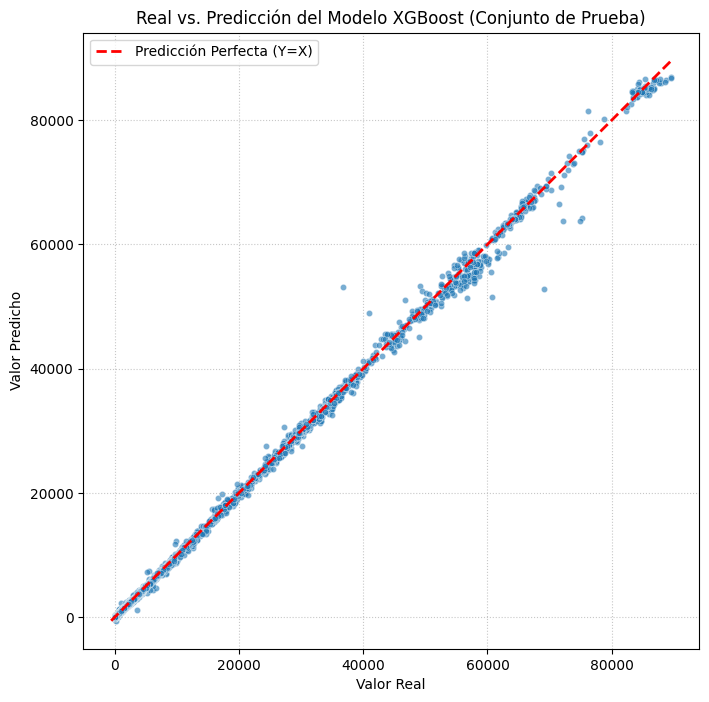

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 8))
# Gráfico de Dispersión (Scatter Plot)
sns.scatterplot(x='Target Real', y='Predicción', data=df_plot, alpha=0.6, s=20)

# Línea de Identidad (Y=X)
# El rango va desde el valor mínimo hasta el valor máximo entre las predicciones y los valores reales
min_val = min(df_plot['Target Real'].min(), df_plot['Predicción'].min())
max_val = max(df_plot['Target Real'].max(), df_plot['Predicción'].max())
line_range = np.linspace(min_val, max_val, 100)

plt.plot(line_range, line_range, color='red', linestyle='--', linewidth=2, label='Predicción Perfecta (Y=X)')

plt.title('Real vs. Predicción del Modelo XGBoost (Conjunto de Prueba)')
plt.xlabel('Valor Real')
plt.ylabel('Valor Predicho')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box') # Fuerza ejes iguales para una mejor visualización de la línea Y=X
plt.show()

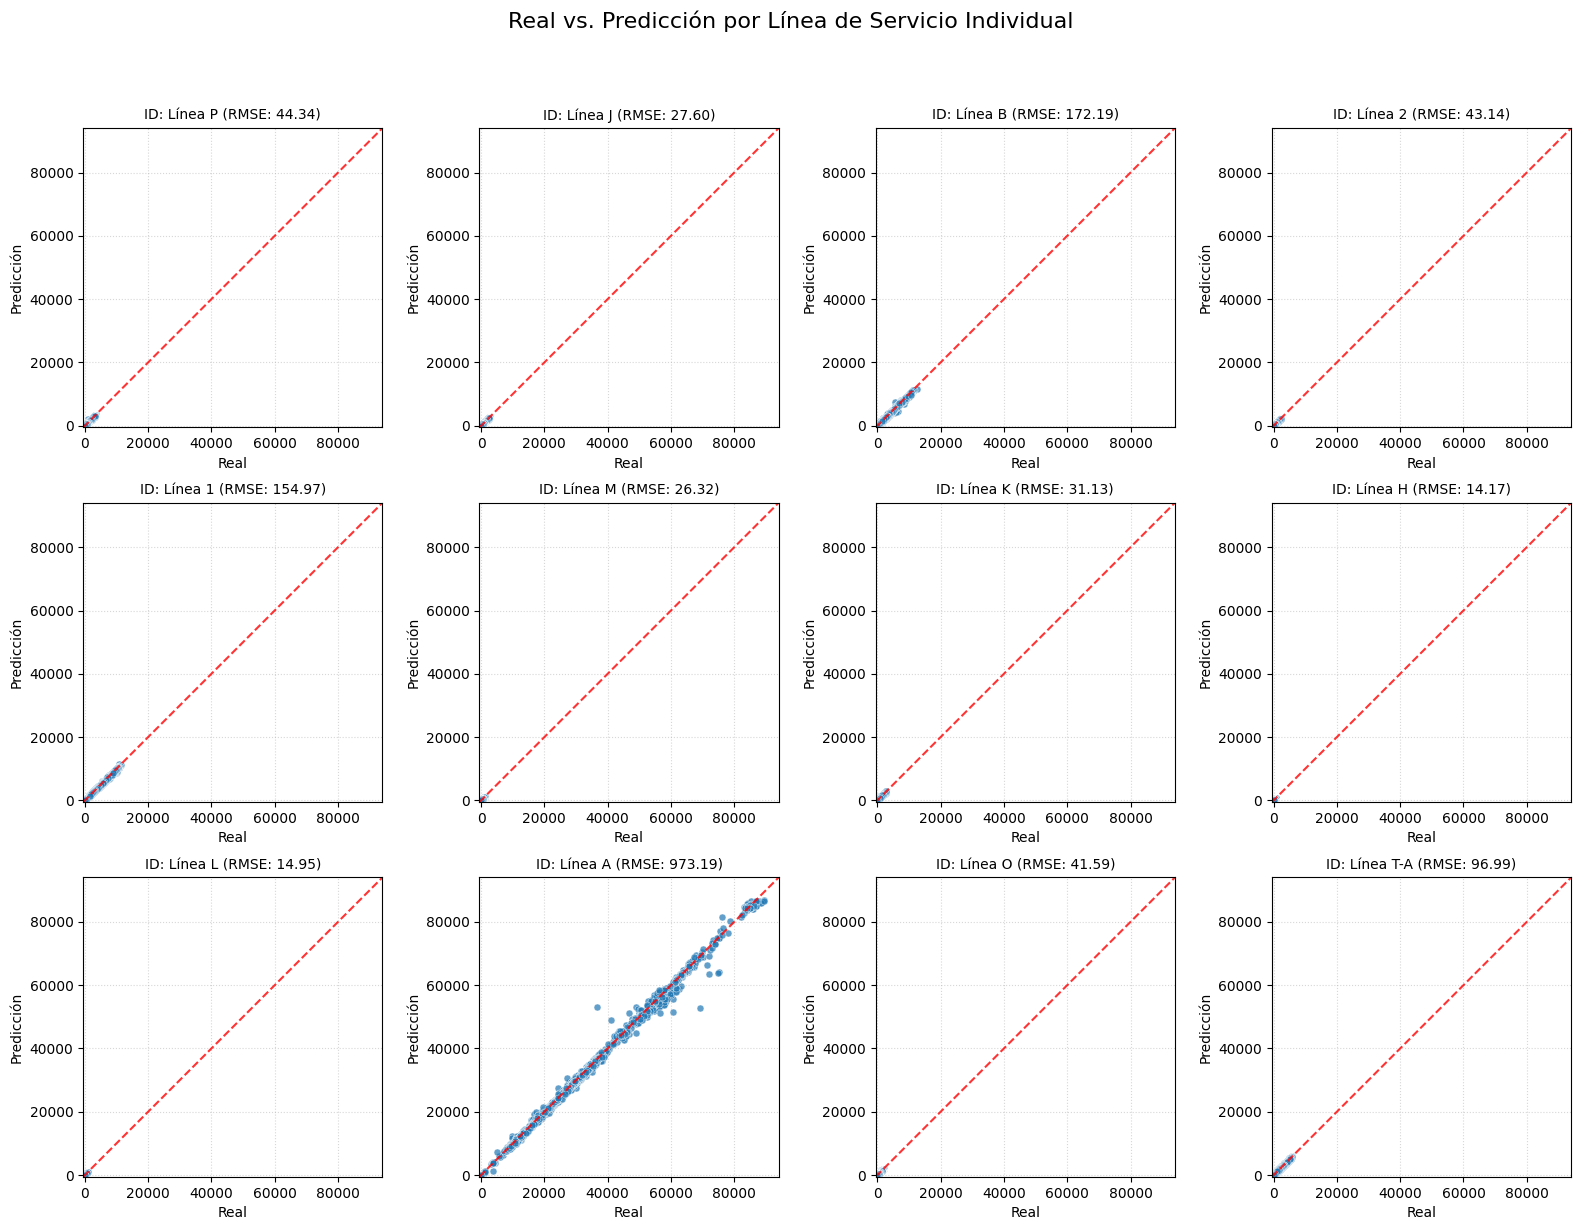

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

unique_lines = df_plot[ID_COLUMN].unique()
n_lines = len(unique_lines)

# Determinar la disposición óptima de los subplots
cols = min(4, n_lines)  # Máximo 4 columnas
rows = int(np.ceil(n_lines / cols))

plt.figure(figsize=(4 * cols, 4 * rows)) # Ajusta el tamaño total de la figura

# Encontrar los valores min/max globales para establecer límites de eje consistentes
global_min = min(df_plot['Target Real'].min(), df_plot['Predicción'].min()) * 0.95
global_max = max(df_plot['Target Real'].max(), df_plot['Predicción'].max()) * 1.05
line_range = np.linspace(global_min, global_max, 100)

for i, line_id in enumerate(unique_lines):
    # Crear el subplot
    plt.subplot(rows, cols, i + 1)

    # Filtrar datos para la línea de servicio actual
    df_line = df_plot[df_plot[ID_COLUMN] == line_id]

    # 1. Gráfico de Dispersión
    sns.scatterplot(x='Target Real', y='Predicción', data=df_line, alpha=0.7, s=25)

    # 2. Línea de Identidad (Y=X)
    plt.plot(line_range, line_range, color='red', linestyle='--', alpha=0.8)

    # 3. Calcular RMSE para esta línea específica
    line_rmse = np.sqrt(mean_squared_error(df_line['Target Real'], df_line['Predicción']))

    plt.title(f'ID: {line_id} (RMSE: {line_rmse:.2f})', fontsize=10)
    plt.xlabel('Real')
    plt.ylabel('Predicción')

    # Establecer límites consistentes para facilitar la comparación
    plt.xlim(global_min, global_max)
    plt.ylim(global_min, global_max)
    plt.gca().set_aspect('equal', adjustable='box') # Fuerza ejes iguales
    plt.grid(True, linestyle=':', alpha=0.5)

plt.suptitle('Real vs. Predicción por Línea de Servicio Individual', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar para el título principal
plt.show()

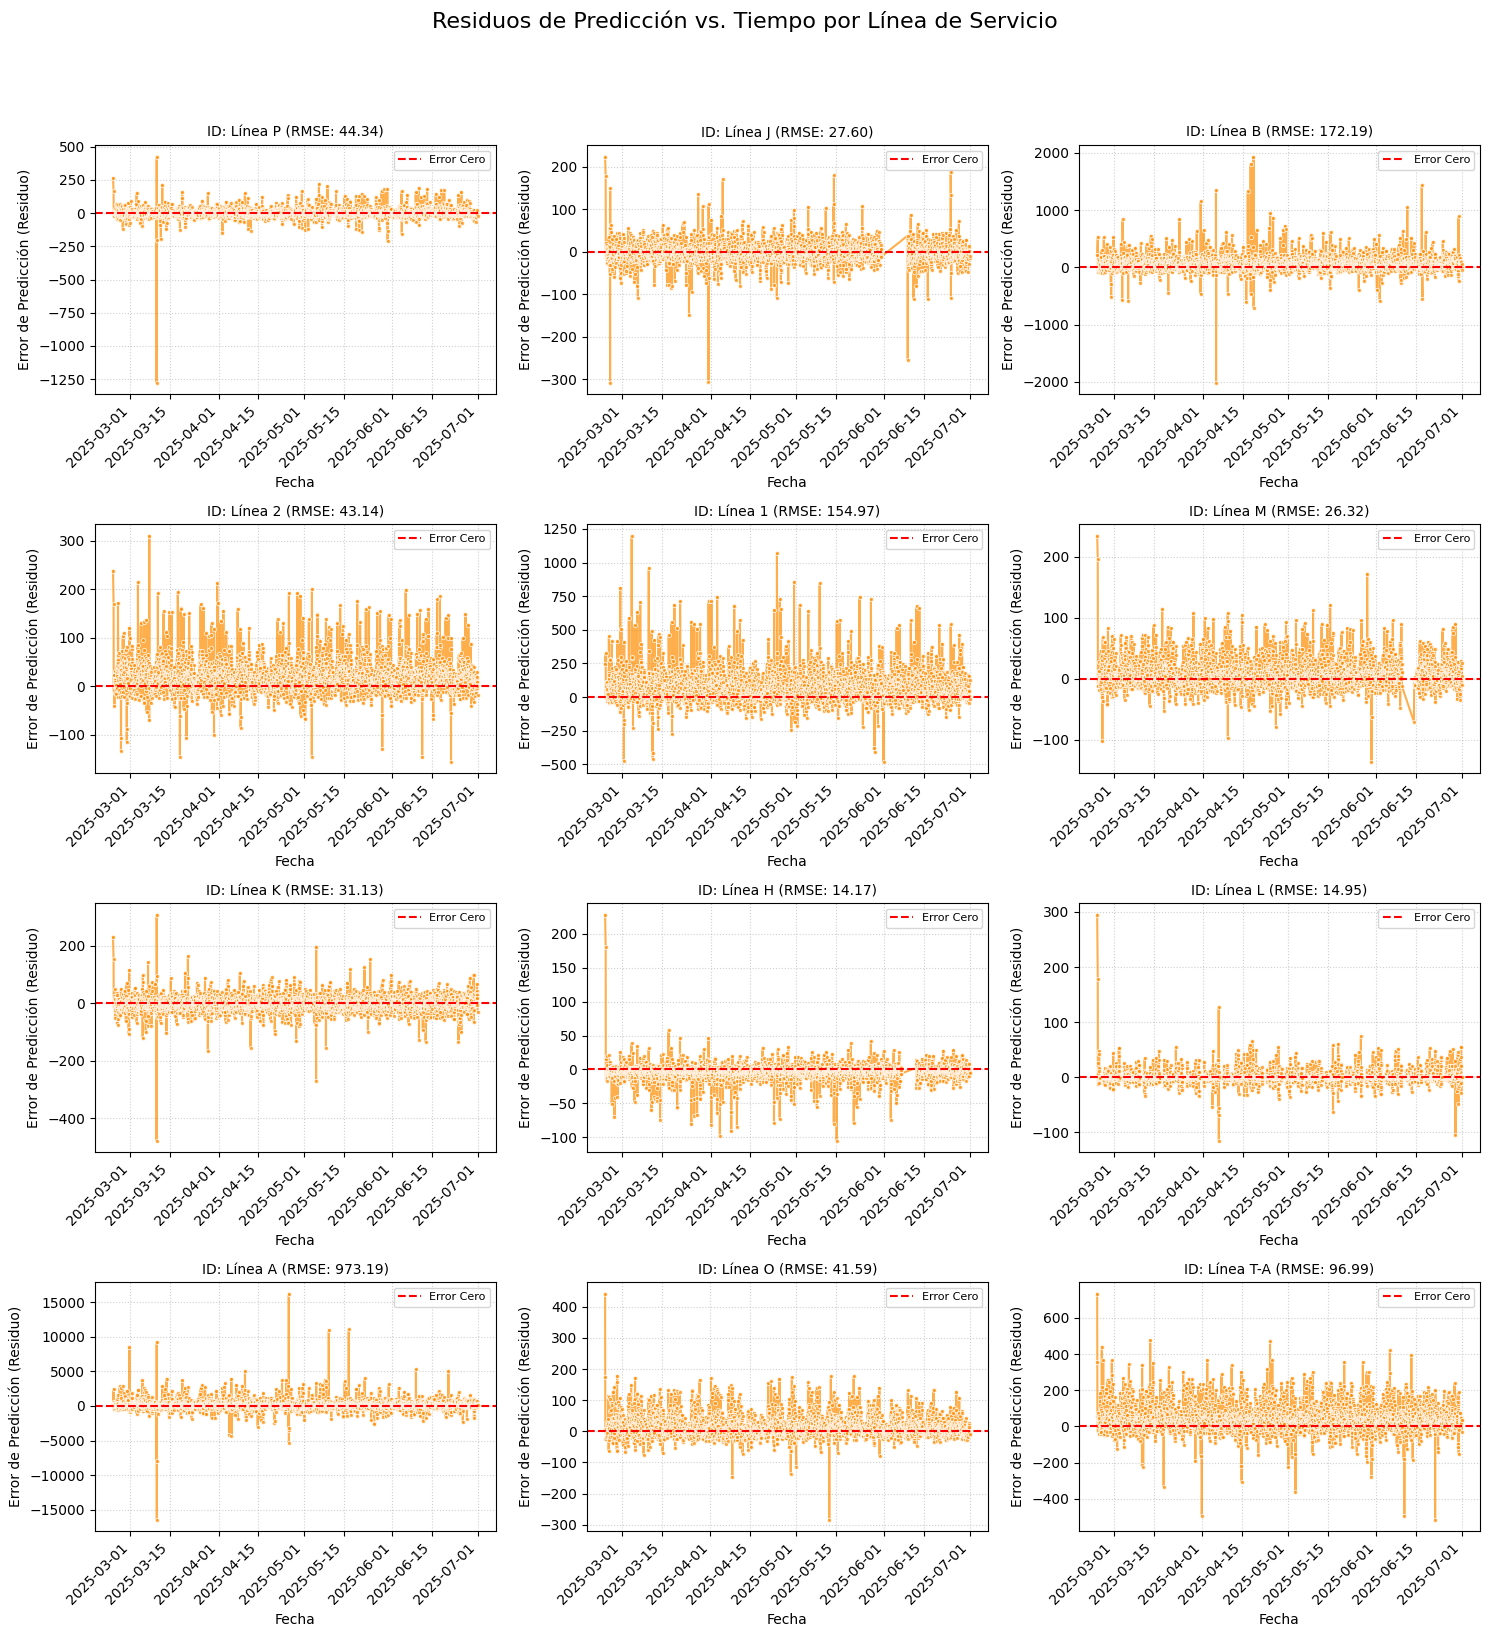

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Calcular el Residuo
df_plot['Residuo'] = df_plot['Target Real'] - df_plot['Predicción']

df_plot['Fecha'] = pd.to_datetime(df_plot['Fecha'])

# 2. Preparación para Subgráficos
unique_lines = df_plot[ID_COLUMN].unique()
n_lines = len(unique_lines)

cols = min(3, n_lines)
rows = int(np.ceil(n_lines / cols))

plt.figure(figsize=(5 * cols, 4 * rows))

# 3. Iterar y Graficar Residuos
for i, line_id in enumerate(unique_lines):
    plt.subplot(rows, cols, i + 1)

    # Filtrar y ordenar los datos por fecha
    df_line = df_plot[df_plot[ID_COLUMN] == line_id].sort_values('Fecha')

    # Graficar los residuos
    sns.lineplot(x='Fecha', y='Residuo', data=df_line,
                 marker='o', markersize=3, alpha=0.7, color='darkorange')

    # Línea de Referencia Cero (Predicción Perfecta)
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Error Cero')

    # Calcular RMSE para esta línea
    line_rmse = np.sqrt(np.mean(df_line['Residuo']**2))

    plt.title(f'ID: {line_id} (RMSE: {line_rmse:.2f})', fontsize=10)
    plt.xlabel('Fecha')
    plt.ylabel('Error de Predicción (Residuo)')
    plt.legend(fontsize=8)
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.xticks(rotation=45, ha='right')

plt.suptitle('Residuos de Predicción vs. Tiempo por Línea de Servicio', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()